# STT810 Project - by Andrew J, Ab Basit, Mahnoor Sheikh

The code was divided and conquered by each one of us where we played to our strengths. The reason we mentioned ***DoNotRun*** on the notebook as a whole is the files and notebooks stayed at different directories within our machines, but we always collaborated on the design and modelling. 

We combined the 3 notebooks using the command below. All 3 aspects of the code, differentiated with different colors can be run individually by having the dataset ***(matched_cities_data.csv)*** and the part of the code under the same directory.

In [ ]:
## Merging the Notebooks

In [ ]:
# import nbformat
# from copy import deepcopy

# def merge_notebooks(notebook_paths):
#     merged_notebook = nbformat.v4.new_notebook()

#     for path in notebook_paths:
#         with open(path, 'r') as f:
#             nb = nbformat.read(f, as_version=4)
#             merged_notebook.cells.extend(nb.cells)

#     return merged_notebook

# notebook_paths = ['preprocessing.ipynb', 'IDA_EDA_STT_Project FInal.ipynb', 'stt project.ipynb']
# merged_nb = merge_notebooks(notebook_paths)

# with open('STT810 Project - Final Code - DoNotRun.ipynb', 'w') as f:
#     nbformat.write(merged_nb, f)

## <font color = 'Orange'> Merging Datasets, Cleaning and Preprocessing

In [53]:
import pandas as pd
import numpy as np
from datetime import timedelta

# List of target cities to focus the analysis on
# This allows filtering the dataset to specific metropolitan areas
target_cities = ['Dallas', 'Denver', 'Detroit', 'Kansas City', 'Los Angeles', 
                 'Miami', 'Minneapolis', 'New York', 'Phoenix', 'Seattle']

# Read the supply chain dataset with robust encoding handling
# Uses latin-1 or cp1252 encoding to handle potential character encoding issues
try:
    # First attempt to read with latin-1 encoding
    supply_chain_df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='latin-1')
except Exception as e:
    print(f"Error with latin-1 encoding: {e}")
    try:
        # Fallback to cp1252 encoding if latin-1 fails
        supply_chain_df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='cp1252')
    except Exception as e:
        print(f"Error with cp1252 encoding: {e}")

# Clean and standardize city names in the supply chain dataset
# - Strip whitespace
# - Remove double spaces
# - Convert to title case for consistent formatting
supply_chain_df['Customer City'] = (supply_chain_df['Customer City']
                                  .str.strip()
                                  .str.replace('  ', ' ')
                                  .str.title())

# Convert shipping date to datetime and extract month and day
# This enables easier merging and date-based analysis
supply_chain_df['shipping date (DateOrders)'] = pd.to_datetime(supply_chain_df['shipping date (DateOrders)'])
supply_chain_df['shipping_month'] = supply_chain_df['shipping date (DateOrders)'].dt.month
supply_chain_df['shipping_day'] = supply_chain_df['shipping date (DateOrders)'].dt.day

# Filter supply chain data to only include specified target cities
# Use case-insensitive matching to ensure comprehensive selection
filtered_supply_df = supply_chain_df[
    supply_chain_df['Customer City'].str.upper().isin([city.upper() for city in target_cities])
].copy()

# Read additional cities data (likely weather or demographic information)
# Clean and standardize city names similar to supply chain data
cities_df = pd.read_csv('AllCitiesData.csv')
cities_df['city'] = cities_df['city'].str.strip().str.title()
cities_df['date'] = pd.to_datetime(cities_df['date'])
cities_df['weather_month'] = cities_df['date'].dt.month
cities_df['weather_day'] = cities_df['date'].dt.day

# Primary merge attempt: Join supply chain data with cities data
# Matches on city name, month, and day
# Left join ensures all supply chain records are retained
final_df = pd.merge(
    filtered_supply_df,
    cities_df,
    left_on=['Customer City', 'shipping_month', 'shipping_day'],
    right_on=['city', 'weather_month', 'weather_day'],
    suffixes=('', '_weather'),
    how='left'  # Keeps all supply chain rows, even without a perfect weather match
)

# Function to find closest date matches when exact date matching fails
# Allows for flexibility in date matching with a configurable day difference threshold
def find_closest_matches(supply_df, cities_df, max_days=2):
    """
    Find the closest weather data matches for supply chain records.
    
    Args:
        supply_df (pd.DataFrame): Supply chain dataset
        cities_df (pd.DataFrame): Cities/weather dataset
        max_days (int, optional): Maximum days difference to consider a match. Defaults to 2.
    
    Returns:
        list: Matches between supply chain and weather records
    """
    matches = []
    # Iterate through each target city
    for city in target_cities:
        # Filter supply chain and weather data for the current city
        city_supply = supply_df[supply_df['Customer City'].str.upper() == city.upper()]
        city_weather = cities_df[cities_df['city'].str.upper() == city.upper()].copy()
        
        # Skip if no data for the city
        if len(city_supply) == 0 or len(city_weather) == 0:
            continue
        
        # For each supply chain record in the city
        for _, supply_row in city_supply.iterrows():
            # Calculate date differences with weather records
            supply_date = supply_row['shipping date (DateOrders)']
            city_weather['date_diff'] = abs(pd.to_datetime(city_weather['date']) - pd.to_datetime(supply_date)).dt.days
            
            # Find weather records within the max_days threshold
            closest_match = city_weather[city_weather['date_diff'] <= max_days]
            
            # If matches found, select the closest date
            if not closest_match.empty:
                closest_weather = closest_match.loc[closest_match['date_diff'].idxmin()]
                matches.append({
                    'supply_chain_row': supply_row,
                    'weather_row': closest_weather,
                    'days_difference': closest_weather['date_diff']
                })
    return matches

# Find the closest date matches using the custom function
matches = find_closest_matches(filtered_supply_df, cities_df)

# Create final merged dataframe with the closest matches
if matches:
    # Extract supply chain and weather rows from matches
    supply_chain_rows = pd.DataFrame([m['supply_chain_row'] for m in matches])
    weather_rows = pd.DataFrame([m['weather_row'] for m in matches])
    days_diff = [m['days_difference'] for m in matches]

    # Concatenate supply chain and weather data
    final_df = pd.concat([
        supply_chain_rows.reset_index(drop=True),
        weather_rows.add_prefix('weather_').reset_index(drop=True)
    ], axis=1)

    # Add column tracking days between dates
    final_df['days_between_dates'] = days_diff
    
    # Remove any duplicate columns that might have been created during merge
    final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# Display matching statistics for analysis and verification
print("\nFinal matching statistics:")
print("Total rows in final dataset:", len(final_df))
print("\nColumns in final dataset:", len(final_df.columns))

# Display a sample of matched records for quick verification
print("\nSample of matched records:")
print(final_df.head())

# Optional: Save the final dataset to a CSV file for further analysis
# Uncomment the following line if you want to save the results
# final_df.to_csv('matched_cities_data.csv', index=False)


Final matching statistics:
Total rows in final dataset: 9900

Columns in final dataset: 90

Sample of matched records:
       Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         2                              1   
2     DEBIT                         2                              1   
3   PAYMENT                         2                              1   
4     DEBIT                         2                              1   

   Benefit per order  Sales per customer   Delivery Status  \
0          22.860001          304.809998  Advance shipping   
1          68.430000          285.140015     Late delivery   
2         -97.339996          324.470001     Late delivery   
3        -425.579987          321.200012     Late delivery   
4          62.270000          311.359985     Late delivery   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0

In [55]:
final_df

Type  Days for shipping (real)  Days for shipment (scheduled)  \
0        DEBIT                         3                              4   
1     TRANSFER                         2                              1   
2        DEBIT                         2                              1   
3      PAYMENT                         2                              1   
4        DEBIT                         2                              1   
...        ...                       ...                            ...   
9895  TRANSFER                         5                              4   
9896  TRANSFER                         2                              4   
9897   PAYMENT                         3                              4   
9898     DEBIT                         2                              4   
9899   PAYMENT                         2                              2   

      Benefit per order  Sales per customer   Delivery Status  \
0             22.860001          304.809998  Advance shipping   
1             68.430000          285.140015     Late delivery   
2            -97.339996          324.470001     Late delivery   
3           -425.579987          321.200012     Late delivery   
4             62.270000          311.359985     Late delivery   
...                 ...                 ...               ...   
9895         143.990005          299.989990     Late delivery   
9896          81.000000          299.989990  Advance shipping   
9897          81.480003          387.980011  Advance shipping   
9898         162.529999          377.980011  Advance shipping   
9899          51.000000          339.980011  Shipping on time   

      Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                      0           73  Sporting Goods   Los Angeles  ...   
1                      1           73  Sporting Goods         Miami  ...   
2                      1           73  Sporting Goods       Detroit  ...   
3                      1           73  Sporting Goods        Dallas  ...   
4                      1           73  Sporting Goods        Dallas  ...   
...                  ...          ...             ...           ...  ...   
9895                   1           45         Fishing   Los Angeles  ...   
9896                   0           45         Fishing       Phoenix  ...   
9897                   0           45         Fishing       Phoenix  ...   
9898                   0           45         Fishing   Los Angeles  ...   
9899                   0           45         Fishing       Phoenix  ...   

     severerisk              sunrise               sunset  moonphase  \
0          10.0  2023-01-16T06:58:12  2023-01-16T17:07:39       0.83   
1          10.0  2023-01-15T07:09:11  2023-01-15T17:51:27       0.79   
2          10.0  2023-01-15T07:58:51  2023-01-15T17:24:43       0.79   
3          10.0  2023-01-15T07:29:49  2023-01-15T17:43:41       0.79   
4          10.0  2023-01-14T07:30:01  2023-01-14T17:42:46       0.75   
...         ...                  ...                  ...        ...   
9895       10.0  2023-01-28T06:52:52  2023-01-28T17:19:26       0.25   
9896       10.0  2023-01-24T07:29:14  2023-01-24T17:51:58       0.10   
9897       10.0  2023-01-25T07:28:44  2023-01-25T17:52:57       0.13   
9898       10.0  2023-01-22T06:56:04  2023-01-22T17:13:29       0.03   
9899       10.0  2023-01-21T07:30:33  2023-01-21T17:49:04       0.00   

                  conditions  \
0     Rain, Partially cloudy   
1                      Clear   
2                      Clear   
3           Partially cloudy   
4           Partially cloudy   
...                      ...   
9895        Partially cloudy   
9896                   Clear   
9897                   Clear   
9898                   Clear   
9899                   Clear   

                                            description               icon  \
0     Partly cloudy throughout the day with rain cle...               rain   
1        

### Note - As the merging, cleaning and preprocessing takes time to process, from the perspective of runtime, we have provided the end ***matched_cities_data.csv*** file. So please keep that in the same directory as your notebook in order to execute it correctly.

## <font color='Green'> **Connecting Data**

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Define the path to your file
file_path = '/content/drive/My Drive/STT Data/Project_data.csv'  # Replace 'matched_cities_data.csv' path with the actual file name path from your PC

# Load the Excel file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()

Type  Days for shipping (real)  Days for shipment (scheduled)  \
0   PAYMENT                         2                              1   
1     DEBIT                         2                              1   
2  TRANSFER                         4                              4   
3  TRANSFER                         6                              4   
4     DEBIT                         2                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0        -425.579987          321.200012     Late delivery   
1          62.270000          311.359985     Late delivery   
2           0.000000          268.760010  Shipping on time   
3          39.700001          211.160004     Late delivery   
4         -44.990002          299.950012  Advance shipping   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   1           73  Sporting Goods        Dallas  ...   
1                   1           73  Sporting Goods        Dallas  ...   
2                   0           73  Sporting Goods        Dallas  ...   
3                   1           17          Cleats        Dallas  ...   
4                   0           17          Cleats        Dallas  ...   

       weather_sunrise       weather_sunset weather_moonphase  \
0  2023-01-16T07:29:36  2023-01-16T17:44:36              0.83   
1  2023-01-15T07:29:49  2023-01-15T17:43:41              0.79   
2  2023-01-17T07:29:21  2023-01-17T17:45:31              0.86   
3  2023-09-16T07:11:21  2023-09-16T19:32:20              0.06   
4  2023-09-14T07:10:04  2023-09-14T19:35:02              0.00   

   weather_conditions                                weather_description  \
0    Partially cloudy                  Partly cloudy throughout the day.   
1    Partially cloudy                  Partly cloudy throughout the day.   
2    Partially cloudy                  Partly cloudy throughout the day.   
3    Partially cloudy                  Partly cloudy throughout the day.   
4      Rain, Overcast  Cloudy skies throughout the day with a chance ...   

        weather_icon                                   weather_stations  \
0  partly-cloudy-day  F8578,KLNC,KDAL,72259903971,KRBD,72258013960,7...   
1  partly-cloudy-day  F8578,KLNC,KDAL,72259903971,KRBD,72258013960,7...   
2  partly-cloudy-day  F8578,KLNC,KDAL,72259903971,KRBD,72258013960,7...   
3  partly-cloudy-day  F8578,KLNC,KDAL,72259903971,KRBD,72258013960,7...   
4               rain  F8578,KLNC,KDAL,72259903971,KRBD,72258013960,7...   

  weather_date_day_month weather_date_diff  days_between_dates  
0             2000-01-16                 0                   0  
1             2000-01-15                 0                   0  
2             2000-01-17                 0                   0  
3             2000-09-16                 0                   0  
4             2000-09-14                 0                   0  

[5 rows x 90 columns]

In [4]:
# Select the specified columns
selected_columns = [
    'Days for shipment (scheduled)', 'Late_delivery_risk', 'Category Name', 'Customer City',
    'Department Name', 'Order Item Quantity', 'shipping_date_day_month', 'weather_tempmax',
    'weather_tempmin', 'weather_temp', 'weather_precip', 'weather_preciptype', 'weather_snow',
    'weather_snowdepth', 'weather_windspeed', 'weather_cloudcover', 'weather_visibility',
    'weather_severerisk', 'weather_conditions', 'weather_description'
]

# Create a new DataFrame with only the selected columns
df_selected = df[selected_columns]

# Display the first few rows of the selected data
df_selected.head()

Days for shipment (scheduled)  Late_delivery_risk   Category Name  \
0                              1                   1  Sporting Goods   
1                              1                   1  Sporting Goods   
2                              4                   0  Sporting Goods   
3                              4                   1          Cleats   
4                              4                   0          Cleats   

  Customer City Department Name  Order Item Quantity shipping_date_day_month  \
0        Dallas         Fitness                    1     2000-01-15 00:54:00   
1        Dallas         Fitness                    1     2000-01-14 23:51:00   
2        Dallas         Fitness                    1     2000-01-16 20:20:00   
3        Dallas         Apparel                    4     2000-09-15 01:04:00   
4        Dallas         Apparel                    5     2000-09-13 18:44:00   

   weather_tempmax  weather_tempmin  weather_temp  weather_precip  \
0             23.7             14.6          19.2           0.000   
1             20.4              8.2          14.6           0.000   
2             26.2             12.2          18.5           0.000   
3             29.9             20.9          25.0           0.000   
4             23.9             21.0          22.0          14.508   

  weather_preciptype  weather_snow  weather_snowdepth  weather_windspeed  \
0               rain           0.0                0.0               32.3   
1               rain           0.0                0.0               40.2   
2               rain           0.0                0.0               17.6   
3                NaN           0.0                0.0               10.4   
4               rain           0.0                0.0               13.1   

   weather_cloudcover  weather_visibility  weather_severerisk  \
0                49.1                16.0                  10   
1                41.1                16.0                  10   
2                38.6                16.0                  10   
3                44.9                15.9                  10   
4                90.7                13.1                  10   

  weather_conditions                                weather_description  
0   Partially cloudy                  Partly cloudy throughout the day.  
1   Partially cloudy                  Partly cloudy throughout the day.  
2   Partially cloudy                  Partly cloudy throughout the day.  
3   Partially cloudy                  Partly cloudy throughout the day.  
4     Rain, Overcast  Cloudy skies throughout the day with a chance ...

## <font color="green"> **Initial Data Analysis (IDA) on Selected Columns**

In [5]:
# Get basic information about the filtered dataset
df_selected.info()

# Display summary statistics for numerical columns
df_selected.describe()

# Check for missing values in the filtered dataset
missing_values = df_selected.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Days for shipment (scheduled)  9900 non-null   int64  
 1   Late_delivery_risk             9900 non-null   int64  
 2   Category Name                  9900 non-null   object 
 3   Customer City                  9900 non-null   object 
 4   Department Name                9900 non-null   object 
 5   Order Item Quantity            9900 non-null   int64  
 6   shipping_date_day_month        9900 non-null   object 
 7   weather_tempmax                9900 non-null   float64
 8   weather_tempmin                9900 non-null   float64
 9   weather_temp                   9900 non-null   float64
 10  weather_precip                 9900 non-null   float64
 11  weather_preciptype             3134 non-null   object 
 12  weather_snow                   9900 non-null   f

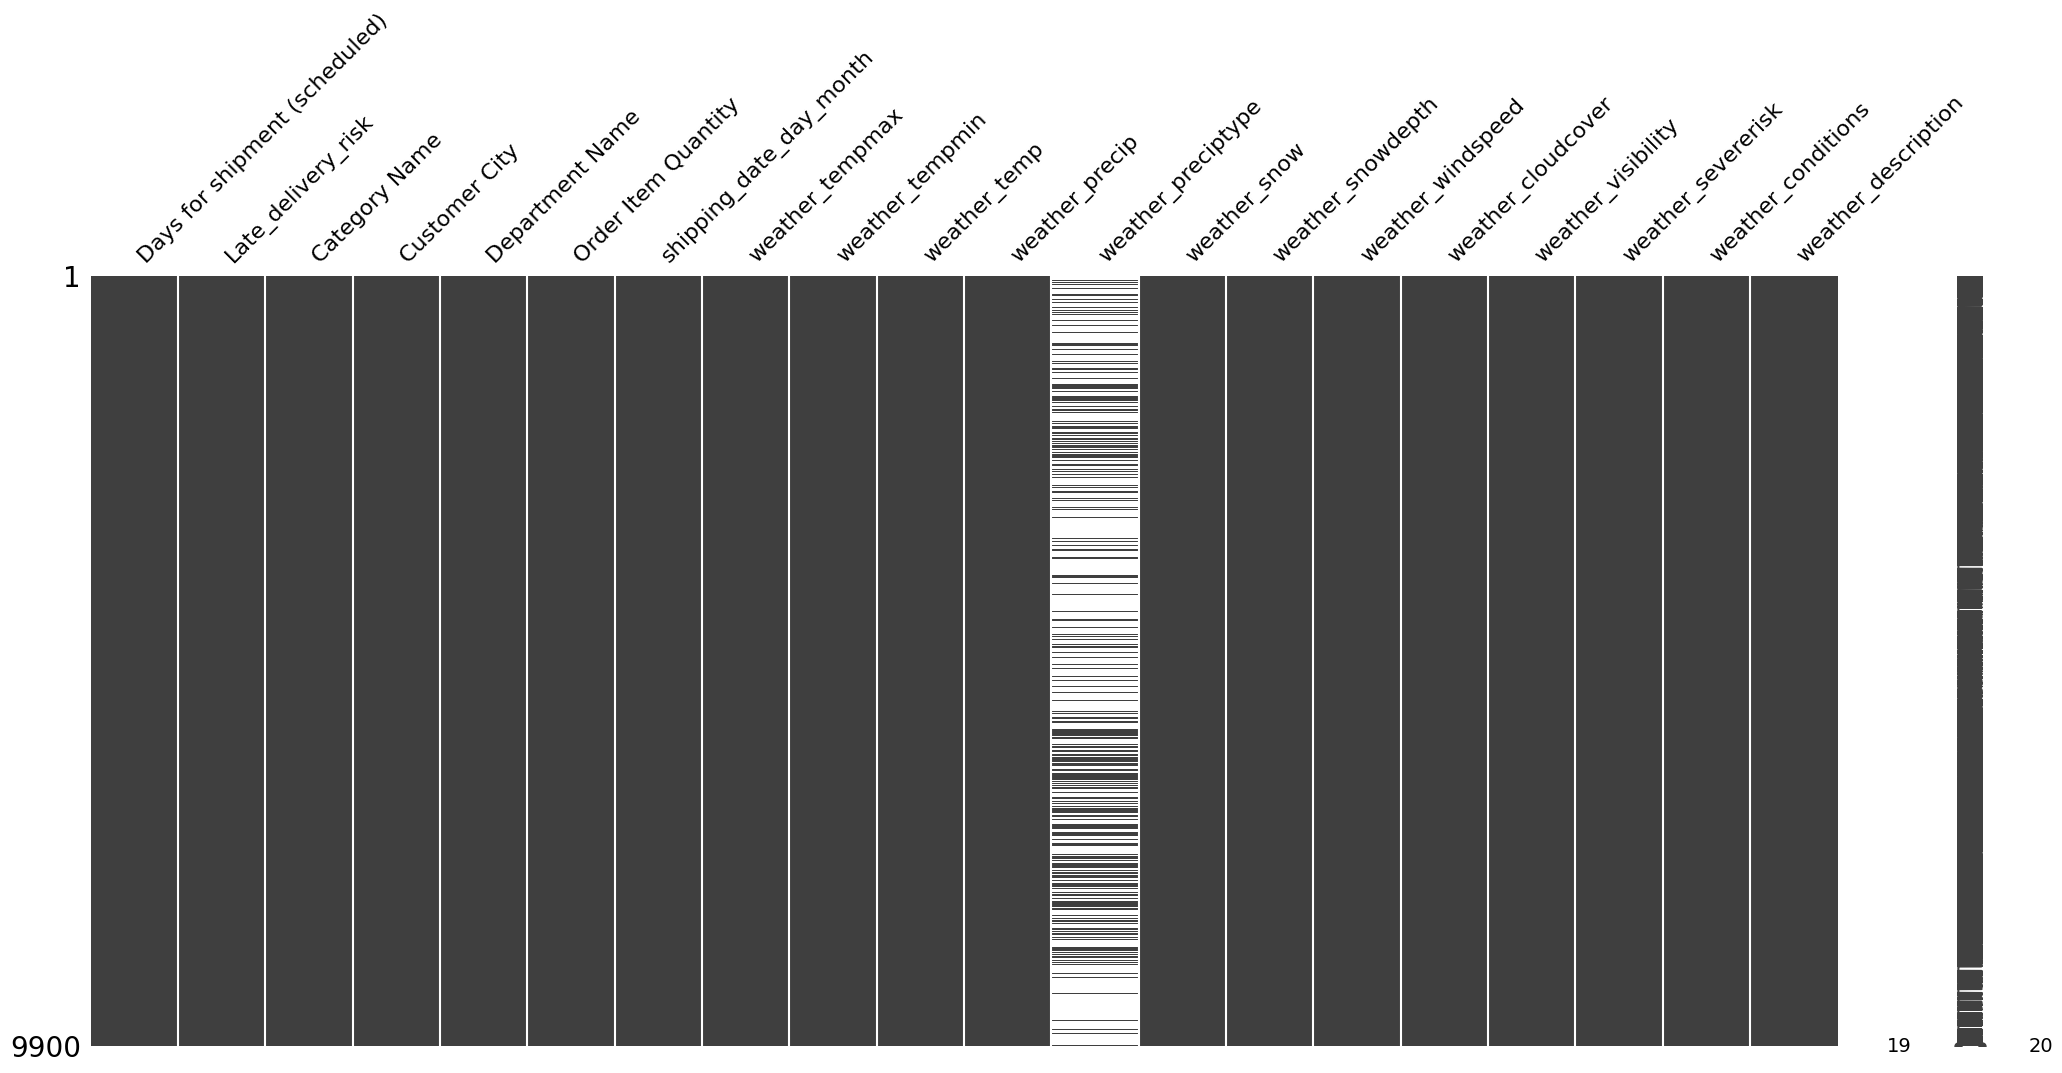

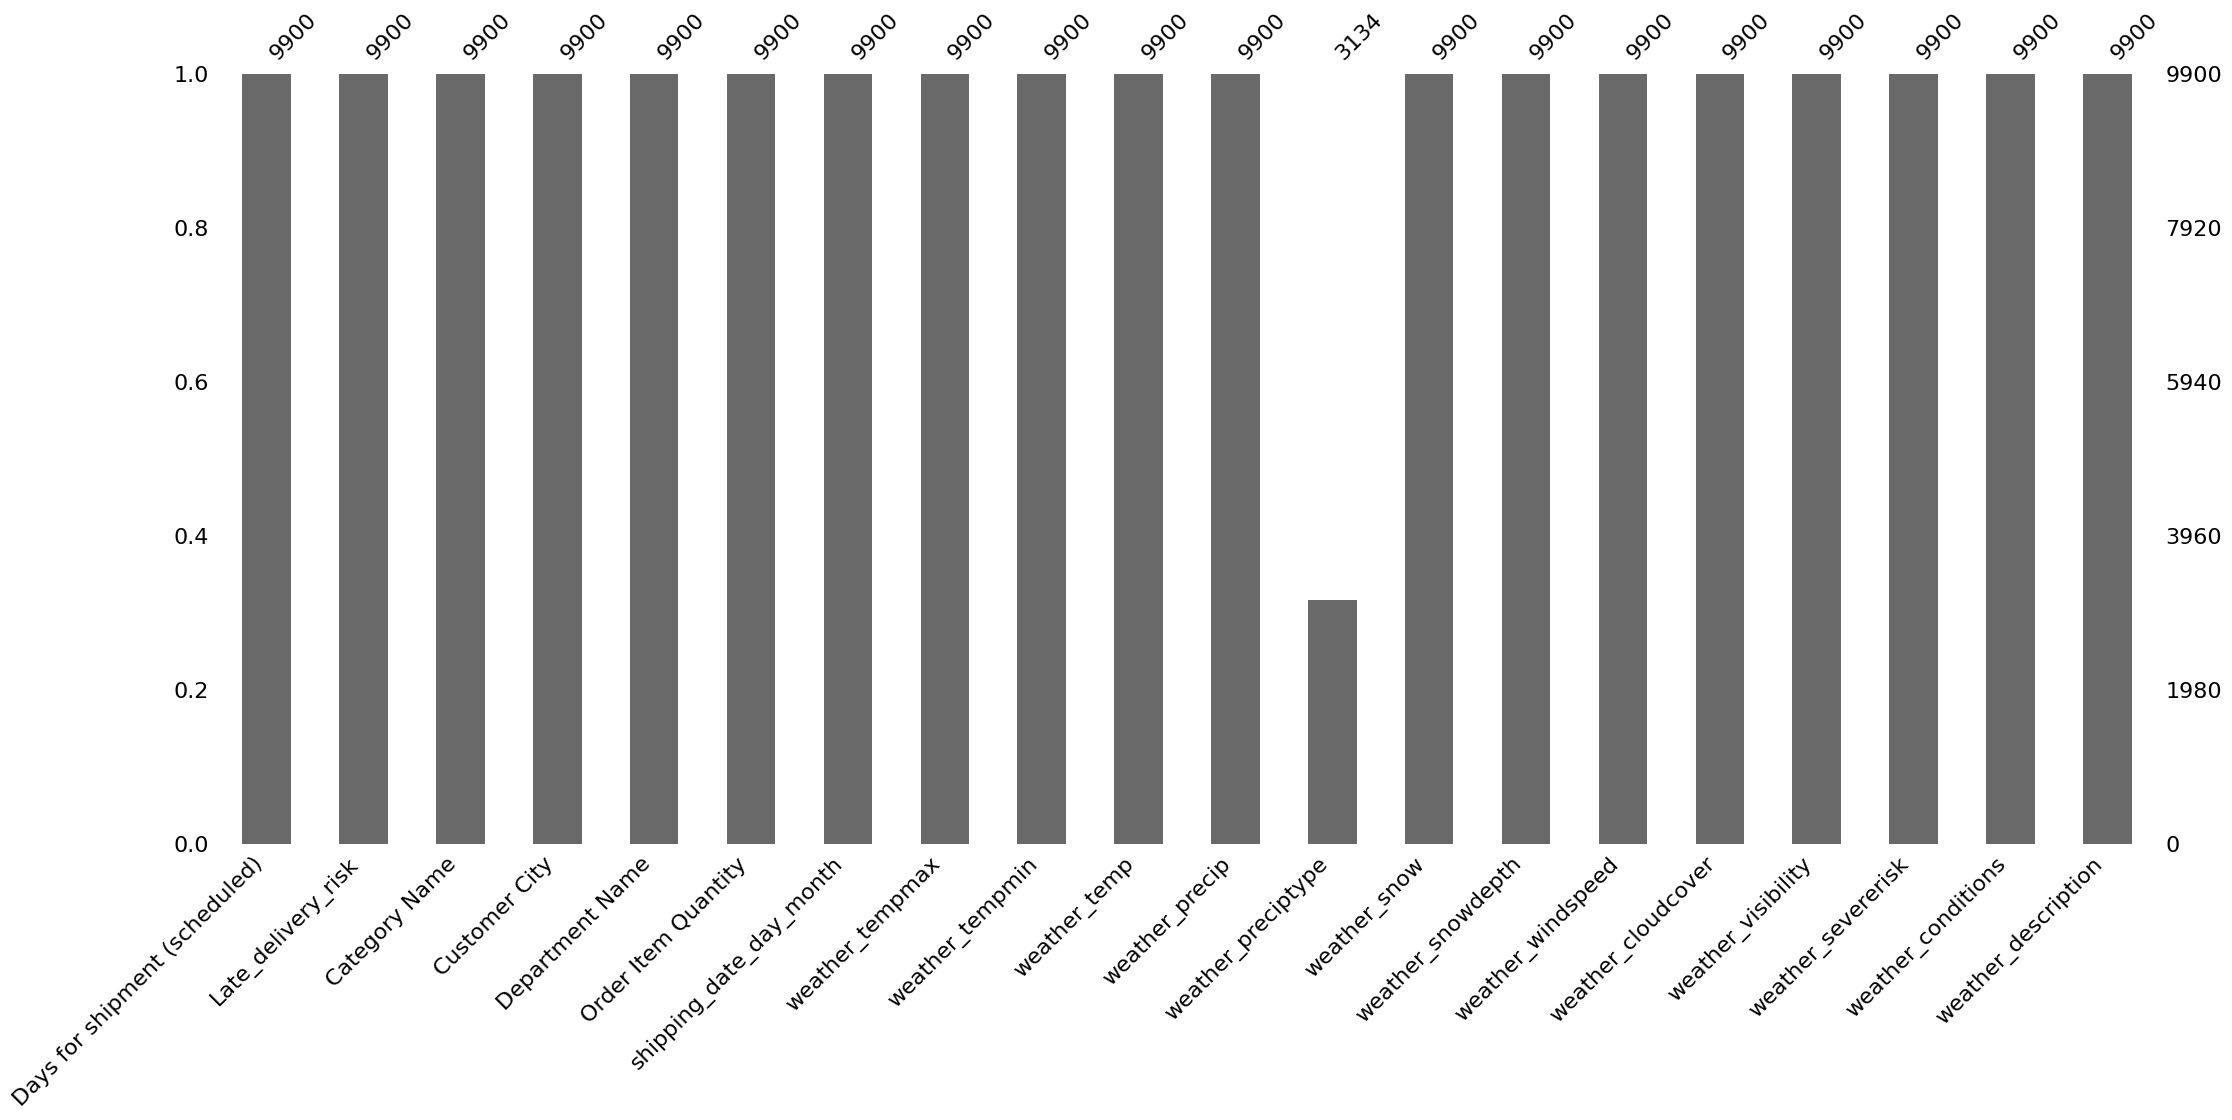

In [6]:
import missingno as msno
import matplotlib.pyplot as plt

# Missing values matrix
msno.matrix(df_selected)
plt.show()

# Missing values bar chart
msno.bar(df_selected)
plt.show()

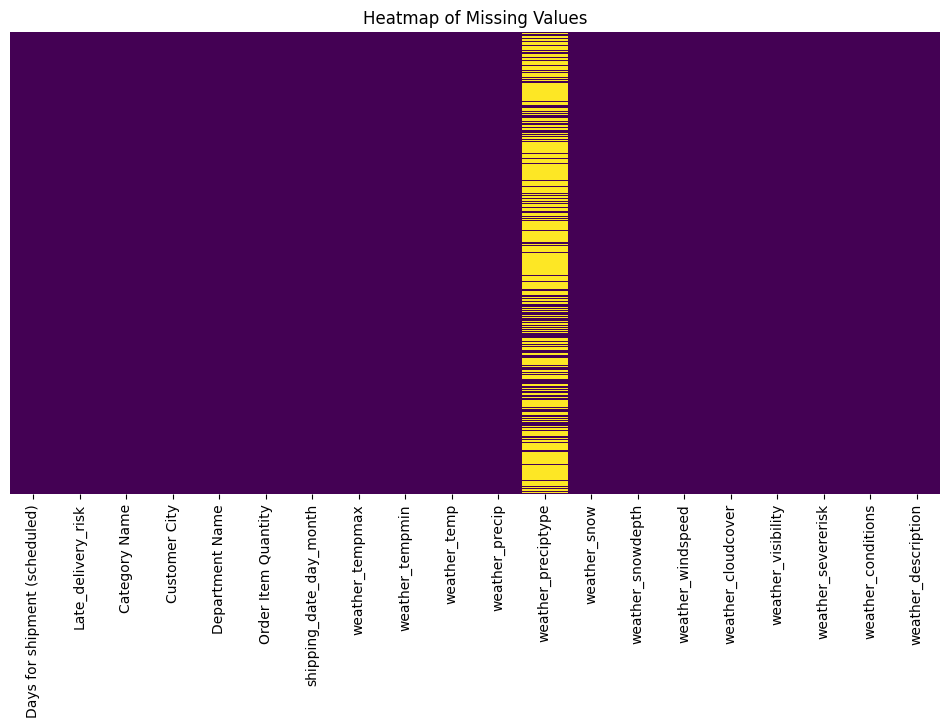

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap to visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df_selected.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

In [8]:
# Customized missing value handling
for column in df_selected.columns:
    if df_selected[column].dtype in ['int64', 'float64']:
        # Fill missing values in numerical columns with the mean
        df_selected[column].fillna(df_selected[column].mean(), inplace=True)
        print(f"Filled missing values in {column} with mean.")
    else:
        # Fill missing values in categorical columns with the mode
        df_selected[column].fillna(df_selected[column].mode()[0], inplace=True)
        print(f"Filled missing values in {column} with mode.")

# Verify if there are any missing values left
print("\nRemaining Missing Values After Custom Handling:")
print(df_selected.isnull().sum())

Filled missing values in Days for shipment (scheduled) with mean.
Filled missing values in Late_delivery_risk with mean.
Filled missing values in Category Name with mode.
Filled missing values in Customer City with mode.
Filled missing values in Department Name with mode.
Filled missing values in Order Item Quantity with mean.
Filled missing values in shipping_date_day_month with mode.
Filled missing values in weather_tempmax with mean.
Filled missing values in weather_tempmin with mean.
Filled missing values in weather_temp with mean.
Filled missing values in weather_precip with mean.
Filled missing values in weather_preciptype with mode.
Filled missing values in weather_snow with mean.
Filled missing values in weather_snowdepth with mean.
Filled missing values in weather_windspeed with mean.
Filled missing values in weather_cloudcover with mean.
Filled missing values in weather_visibility with mean.
Filled missing values in weather_severerisk with mean.
Filled missing values in weath

<ipython-input-8-934db05c910d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_selected[column].fillna(df_selected[column].mean(), inplace=True)
<ipython-input-8-934db05c910d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[column].fillna(df_selected[column].mean(), inplace=True)
<ipython-input-8-934db05c910d>:9: FutureWarning

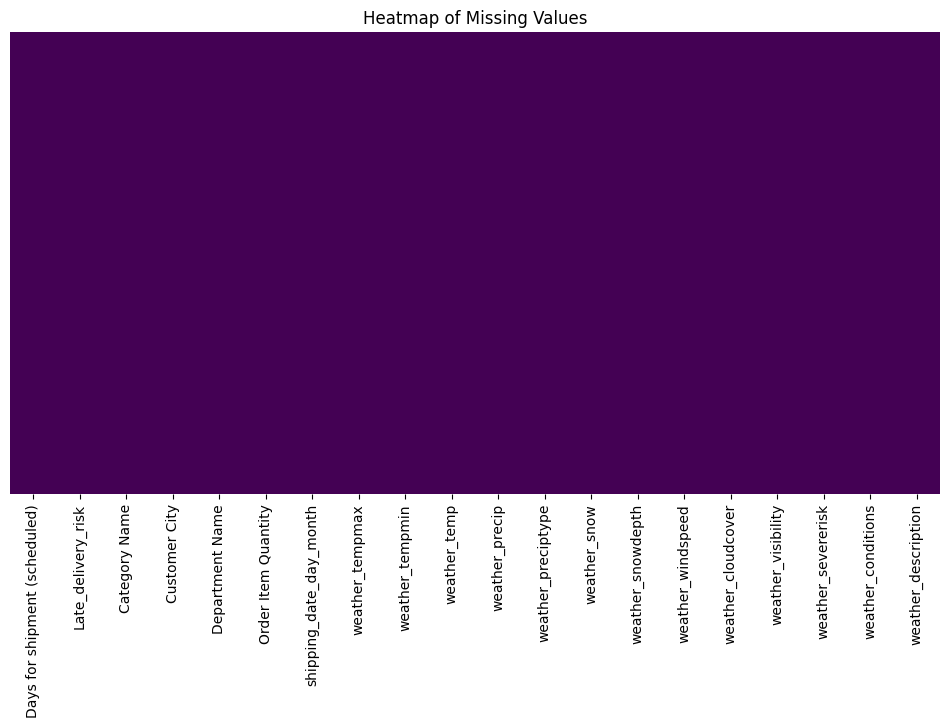

In [9]:
# Missingness after imputations
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap to visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df_selected.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

## <font color='Green'> **Analyze Correlation and Covariance**

In [10]:
# Filter the DataFrame to include only numerical columns
numerical_columns = df_selected.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df_selected[numerical_columns]

# Compute the correlation matrix for numerical columns
correlation_matrix = df_numerical.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                               Days for shipment (scheduled)  \
Days for shipment (scheduled)                       1.000000   
Late_delivery_risk                                 -0.372165   
Order Item Quantity                                -0.008426   
weather_tempmax                                    -0.000854   
weather_tempmin                                    -0.006751   
weather_temp                                       -0.004313   
weather_precip                                     -0.008462   
weather_snow                                        0.026557   
weather_snowdepth                                   0.033119   
weather_windspeed                                  -0.004255   
weather_cloudcover                                  0.002099   
weather_visibility                                 -0.002840   
weather_severerisk                                 -0.002475   

                               Late_delivery_risk  Order Item Quantity  \
Days for 

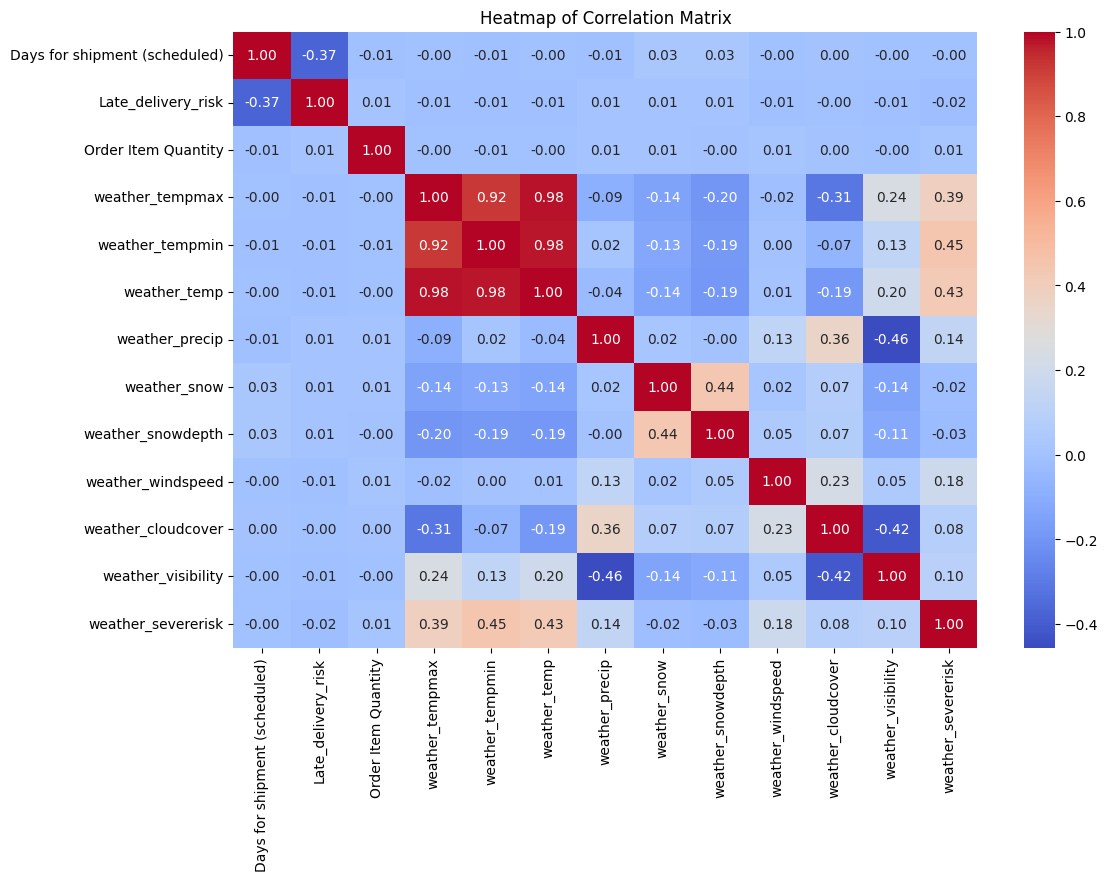

In [11]:
# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlation Matrix")
plt.show()

## <font color = 'Green'> **Covariance Matrix for Numerical Columns**

In [12]:
# Compute the covariance matrix for numerical columns
covariance_matrix = df_numerical.cov()

# Display the covariance matrix
print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
                               Days for shipment (scheduled)  \
Days for shipment (scheduled)                       1.950592   
Late_delivery_risk                                 -0.259241   
Order Item Quantity                                -0.017024   
weather_tempmax                                    -0.010505   
weather_tempmin                                    -0.076453   
weather_temp                                       -0.049826   
weather_precip                                     -0.094093   
weather_snow                                        0.014750   
weather_snowdepth                                   0.017550   
weather_windspeed                                  -0.041675   
weather_cloudcover                                  0.090250   
weather_visibility                                 -0.007822   
weather_severerisk                                 -0.063247   

                               Late_delivery_risk  Order Item Quantity  \
Days for s

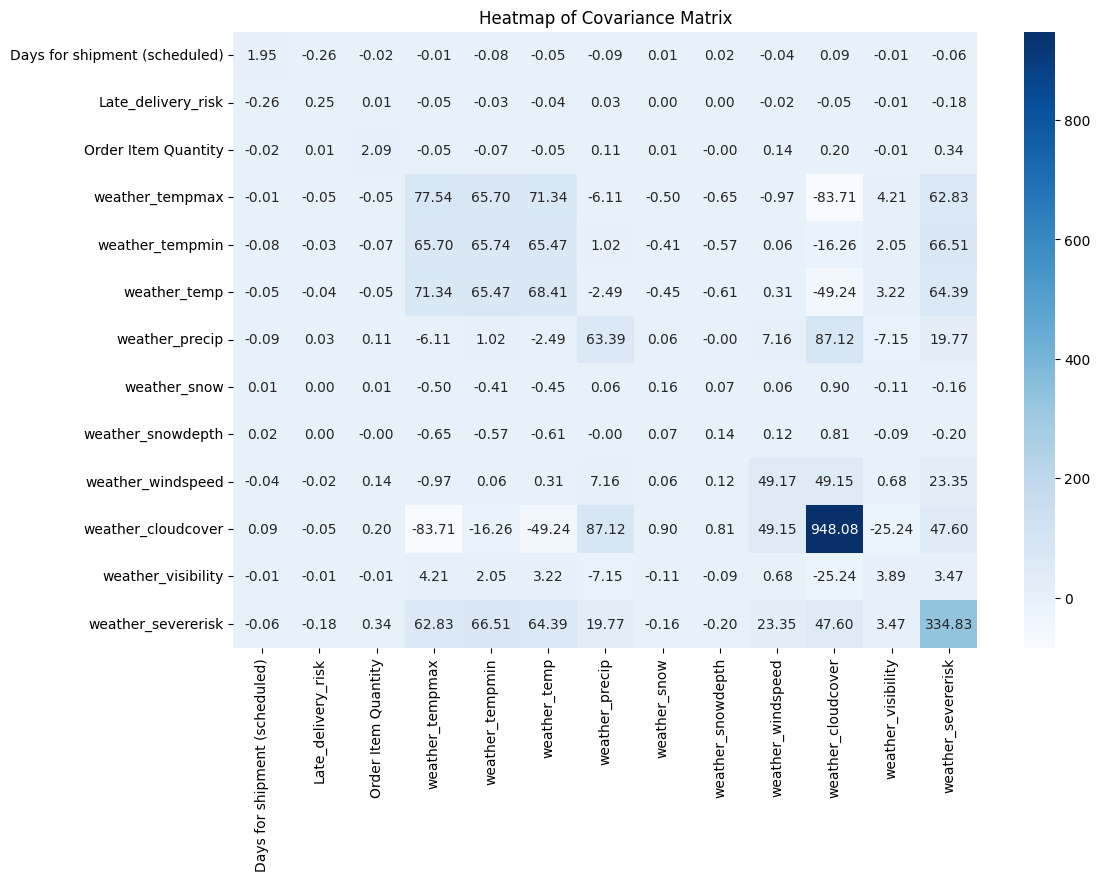

In [13]:
# Plot a heatmap of the covariance matrix
plt.figure(figsize=(12, 8))
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Heatmap of Covariance Matrix")
plt.show()

## <font color ='GREEN'> **Univariate Analysis**

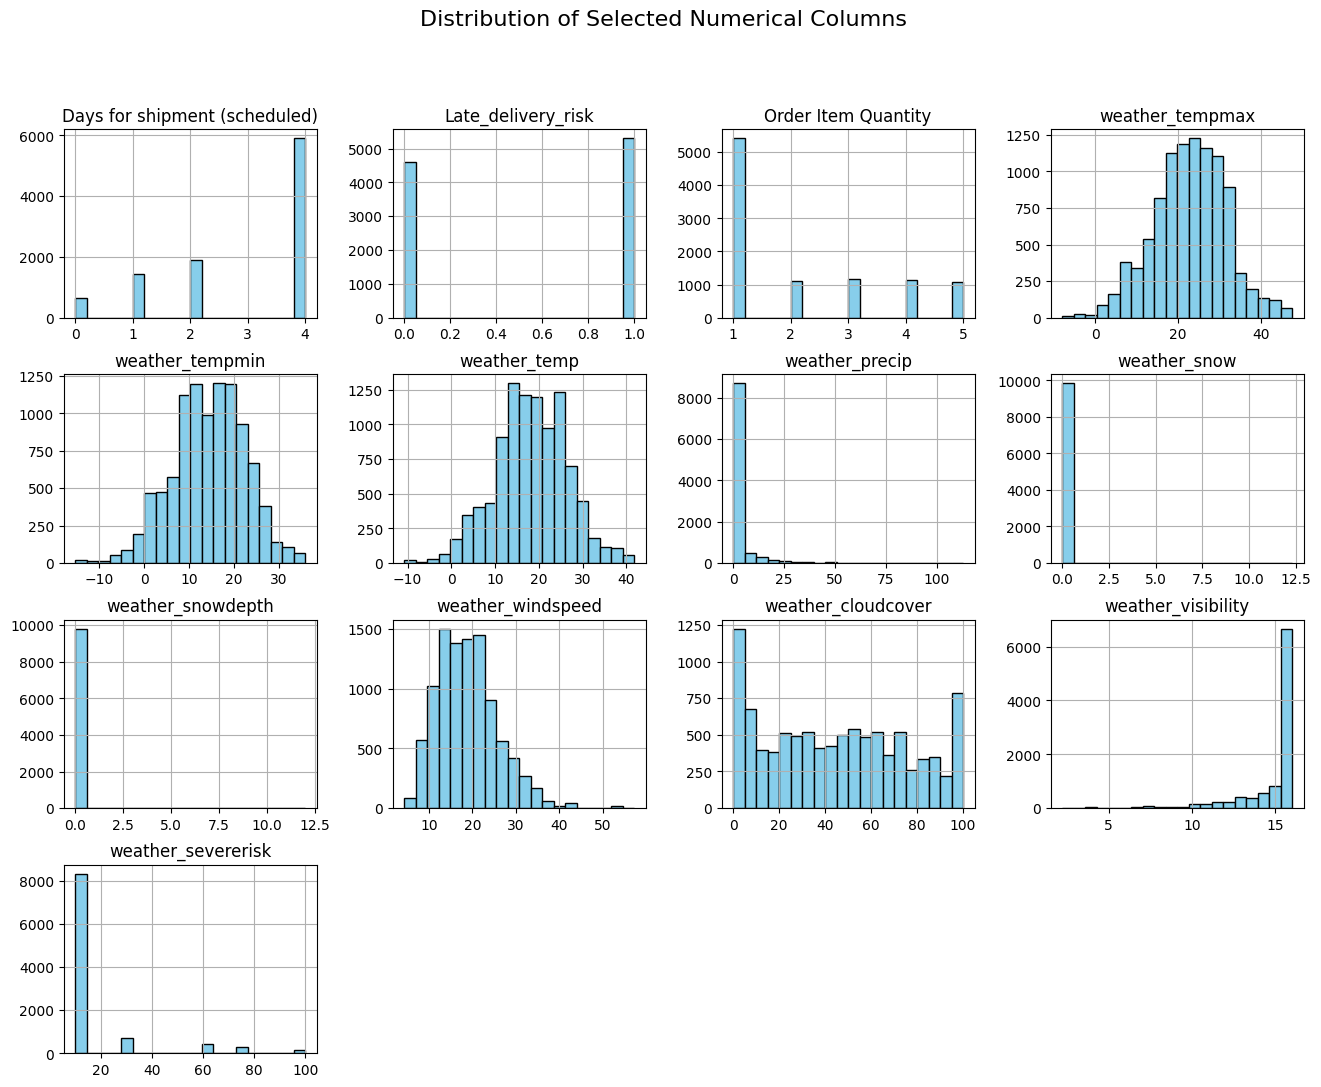

In [14]:
# List of numerical columns in your selected data
numerical_columns = [
    'Days for shipment (scheduled)', 'Late_delivery_risk', 'Order Item Quantity',
    'weather_tempmax', 'weather_tempmin', 'weather_temp', 'weather_precip',
    'weather_snow', 'weather_snowdepth', 'weather_windspeed',
    'weather_cloudcover', 'weather_visibility', 'weather_severerisk'
]

# Plot histograms for the numerical columns in your selection
df_selected[numerical_columns].hist(figsize=(16, 12), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Selected Numerical Columns", fontsize=16)
plt.show()

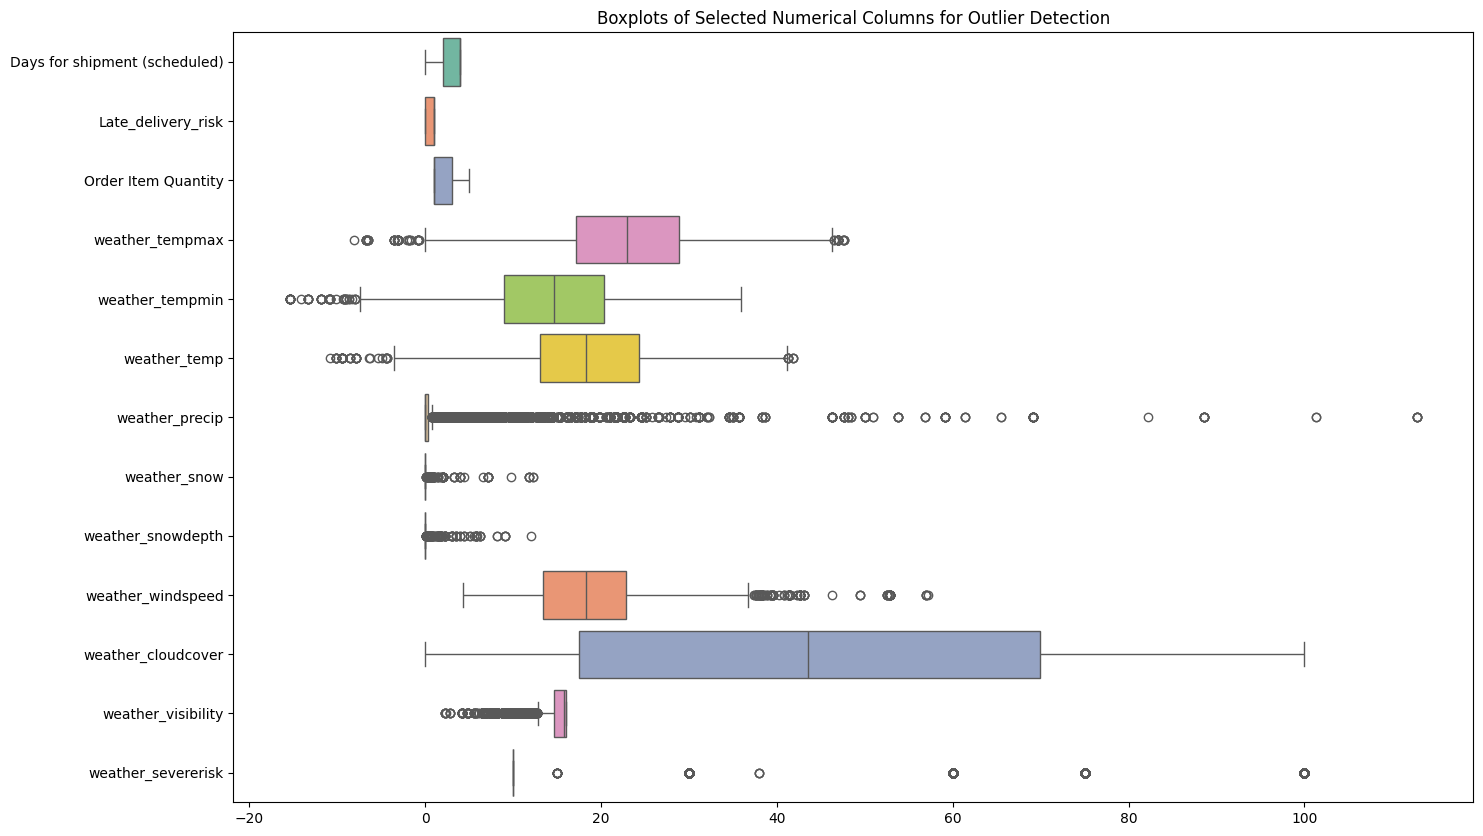

In [15]:
# Plot boxplots for numerical columns in your selection
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_selected[numerical_columns], orient="h", palette="Set2")
plt.title("Boxplots of Selected Numerical Columns for Outlier Detection")
plt.show()

## <font color ='Green'> **Multivariate Analysis**

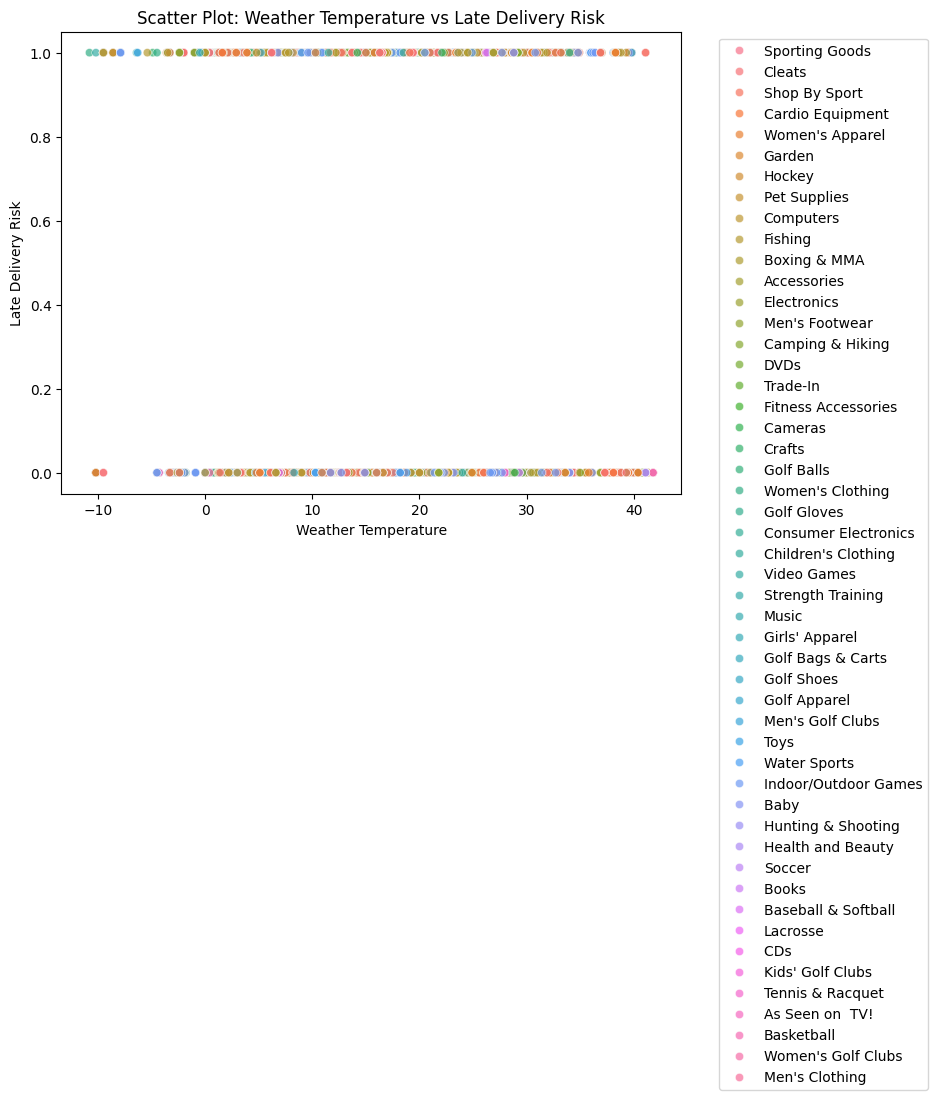

In [16]:
# Scatter plot to visualize relationship between selected numerical variables
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='weather_temp', y='Late_delivery_risk',
    data=df_selected, hue='Category Name', alpha=0.7
)
plt.title("Scatter Plot: Weather Temperature vs Late Delivery Risk")
plt.xlabel("Weather Temperature")
plt.ylabel("Late Delivery Risk")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

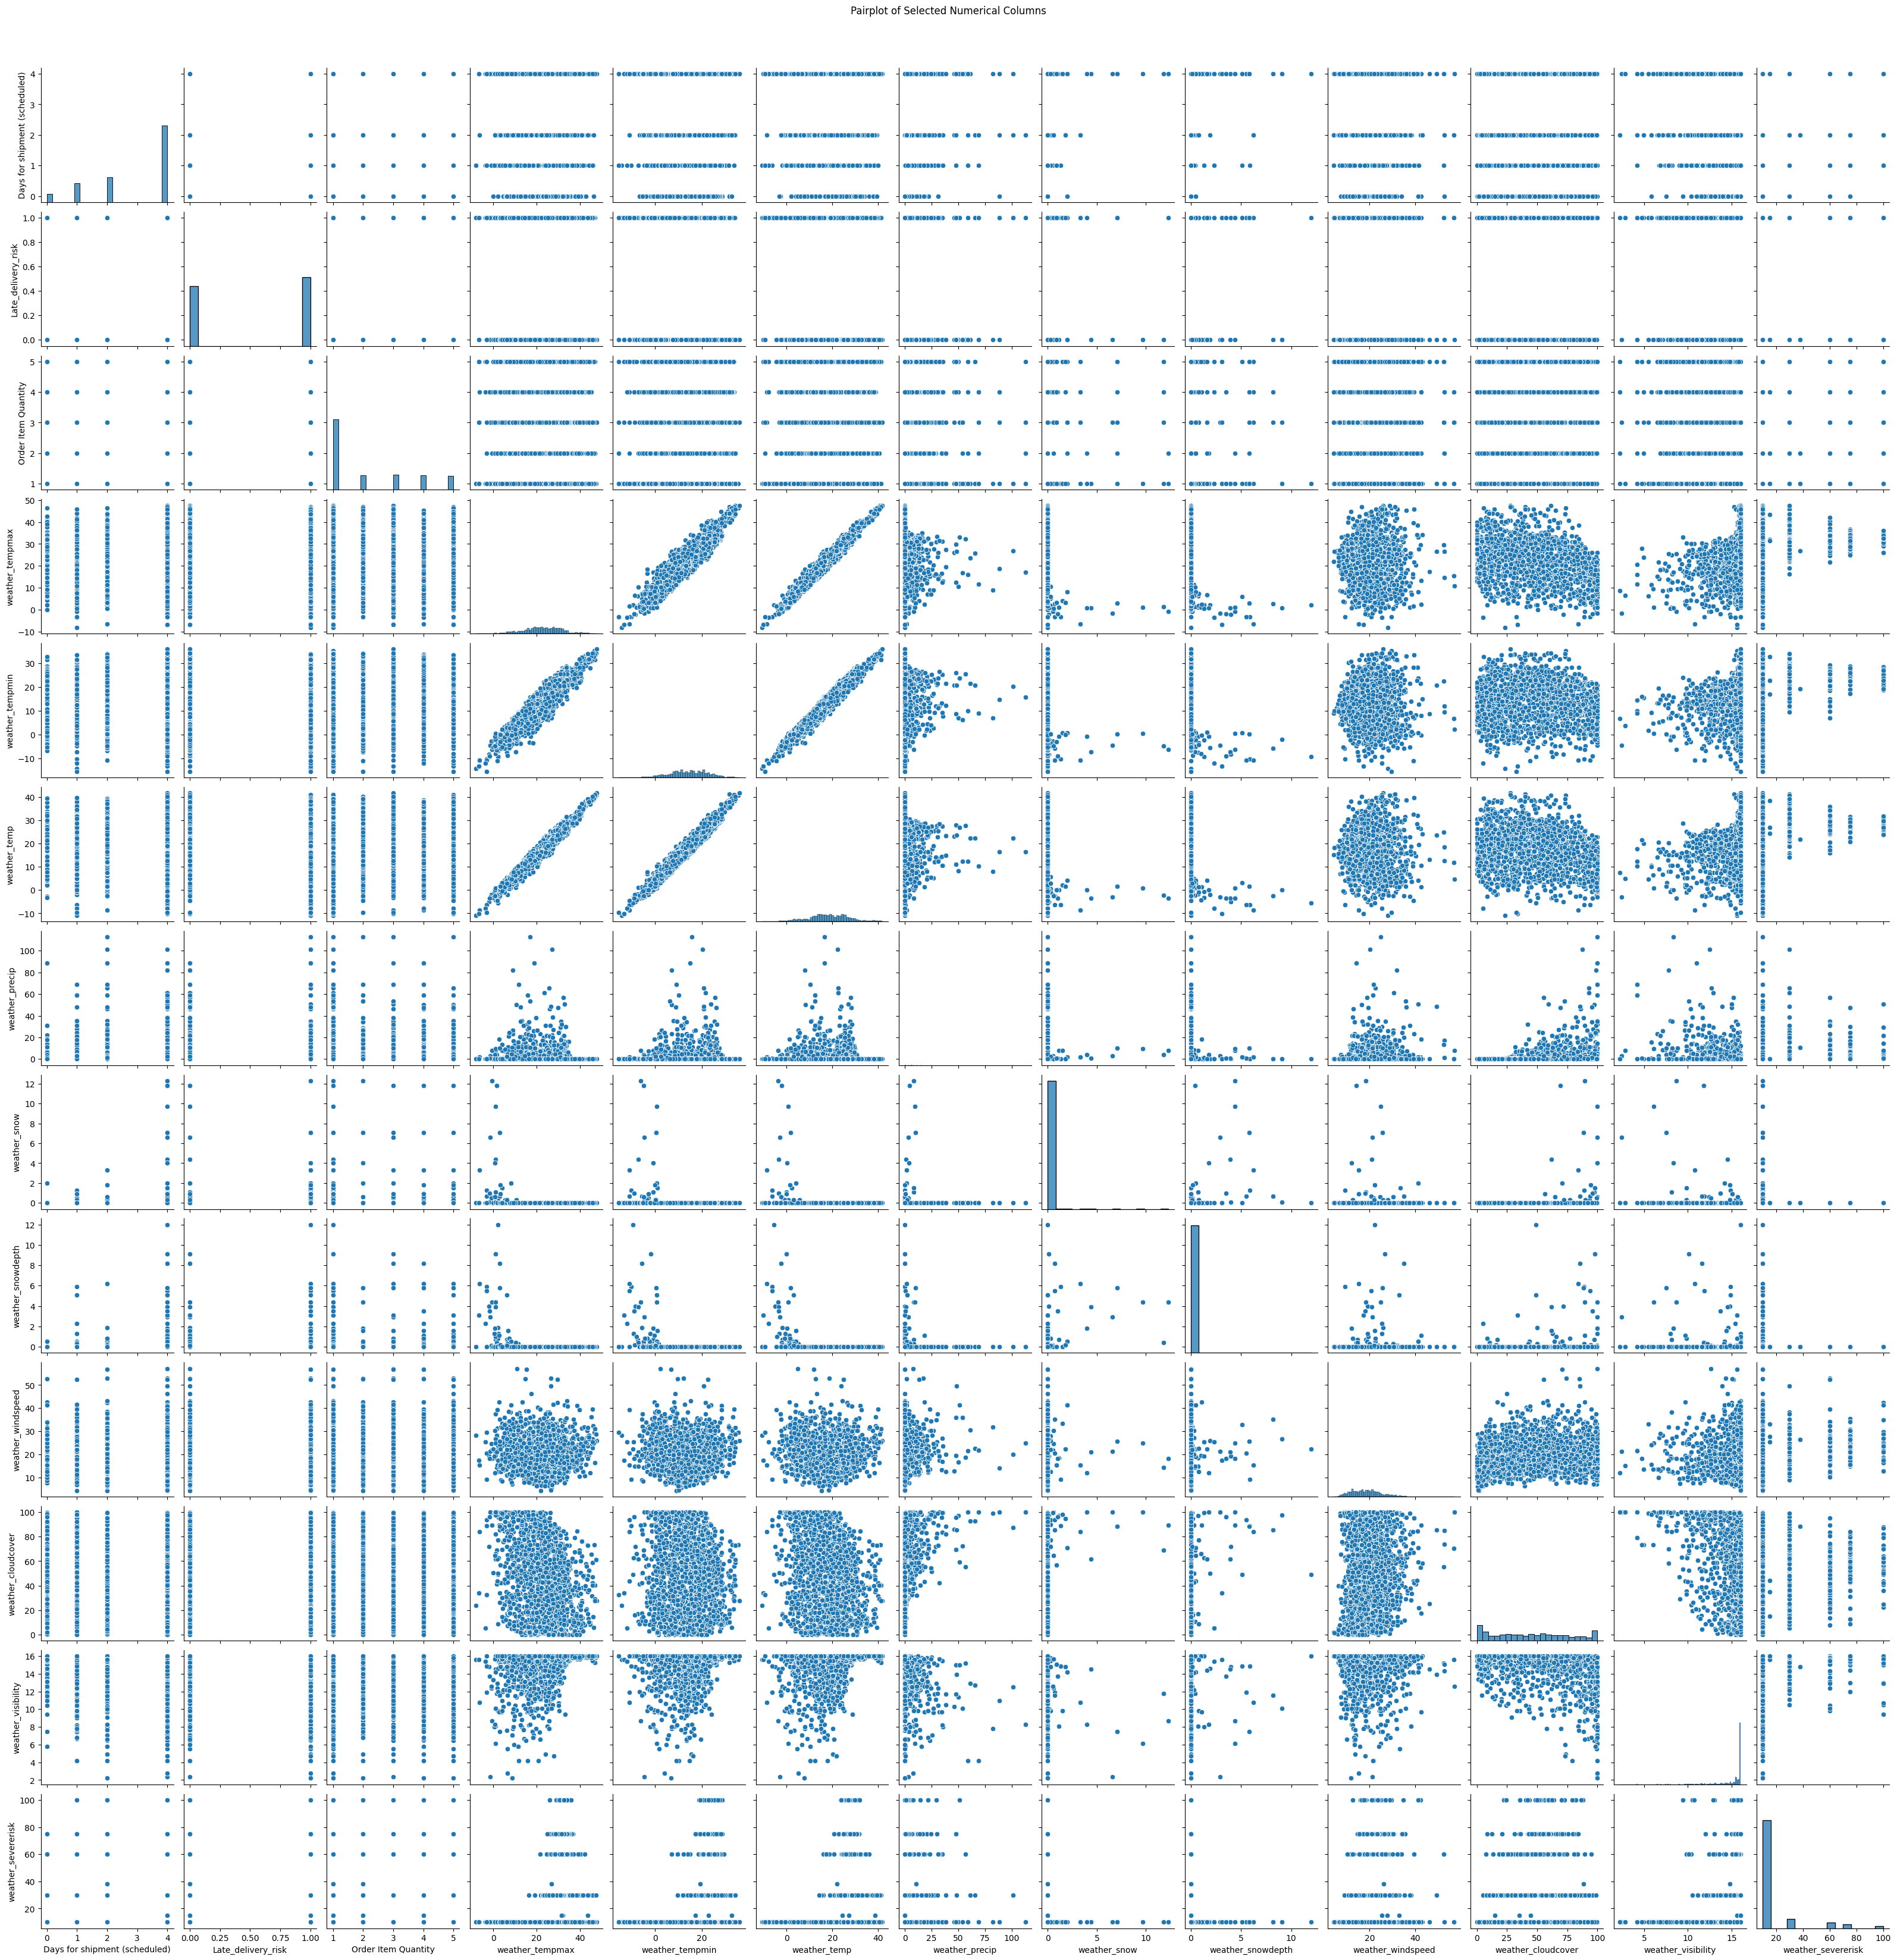

In [17]:
# Pairplot for numerical columns in the selected dataset
sns.pairplot(df_selected[numerical_columns])
plt.suptitle("Pairplot of Selected Numerical Columns", y=1.02)
plt.show()

## <font color="GREEN"> **Sample Statistics**

In [18]:
# Compute summary statistics for numerical columns
numerical_stats = df_selected[numerical_columns].describe()

# Display the summary statistics
print("Summary Statistics for Numerical Columns:")
print(numerical_stats)

Summary Statistics for Numerical Columns:
       Days for shipment (scheduled)  Late_delivery_risk  Order Item Quantity  \
count                    9900.000000         9900.000000          9900.000000   
mean                        2.917071            0.535657             2.129697   
std                         1.396636            0.498752             1.446681   
min                         0.000000            0.000000             1.000000   
25%                         2.000000            0.000000             1.000000   
50%                         4.000000            1.000000             1.000000   
75%                         4.000000            1.000000             3.000000   
max                         4.000000            1.000000             5.000000   

       weather_tempmax  weather_tempmin  weather_temp  weather_precip  \
count      9900.000000      9900.000000   9900.000000     9900.000000   
mean         22.777232        14.292313     18.256485        2.458295   
std      

In [19]:
# Define categorical_columns
categorical_columns = df_selected.select_dtypes(include=['object']).columns

# Compute frequency counts for categorical columns
print("Frequency Counts for Categorical Columns:")
for col in categorical_columns:
    print(f"\nColumn: {col}")
    print(df_selected[col].value_counts())

Frequency Counts for Categorical Columns:

Column: Category Name
Category Name
Cleats                  1345
Men's Footwear          1217
Women's Apparel         1146
Indoor/Outdoor Games    1118
Fishing                  964
Water Sports             799
Camping & Hiking         727
Cardio Equipment         686
Shop By Sport            621
Electronics              183
Accessories               96
Golf Balls                76
Golf Gloves               63
Girls' Apparel            62
Trade-In                  47
Video Games               42
Baseball & Softball       37
Pet Supplies              34
Cameras                   34
Hockey                    32
Children's Clothing       31
Sporting Goods            31
Women's Clothing          30
Computers                 30
Toys                      29
Golf Shoes                28
DVDs                      27
Boxing & MMA              27
Hunting & Shooting        26
Music                     26
Crafts                    24
Consumer Electronics  

In [20]:
# Skewness and kurtosis for numerical columns
skewness = df_selected[numerical_columns].skew()
kurtosis = df_selected[numerical_columns].kurt()

print("\nSkewness for Numerical Columns:")
print(skewness)

print("\nKurtosis for Numerical Columns:")
print(kurtosis)


Skewness for Numerical Columns:
Days for shipment (scheduled)    -0.744658
Late_delivery_risk               -0.143012
Order Item Quantity               0.869180
weather_tempmax                  -0.138909
weather_tempmin                  -0.223022
weather_temp                     -0.114400
weather_precip                    6.048049
weather_snow                     23.396009
weather_snowdepth                17.797440
weather_windspeed                 0.803085
weather_cloudcover                0.202902
weather_visibility               -2.634236
weather_severerisk                2.879683
dtype: float64

Kurtosis for Numerical Columns:
Days for shipment (scheduled)     -0.998101
Late_delivery_risk                -1.979948
Order Item Quantity               -0.762288
weather_tempmax                    0.084864
weather_tempmin                   -0.042382
weather_temp                       0.108690
weather_precip                    51.131769
weather_snow                     614.670405
weather_

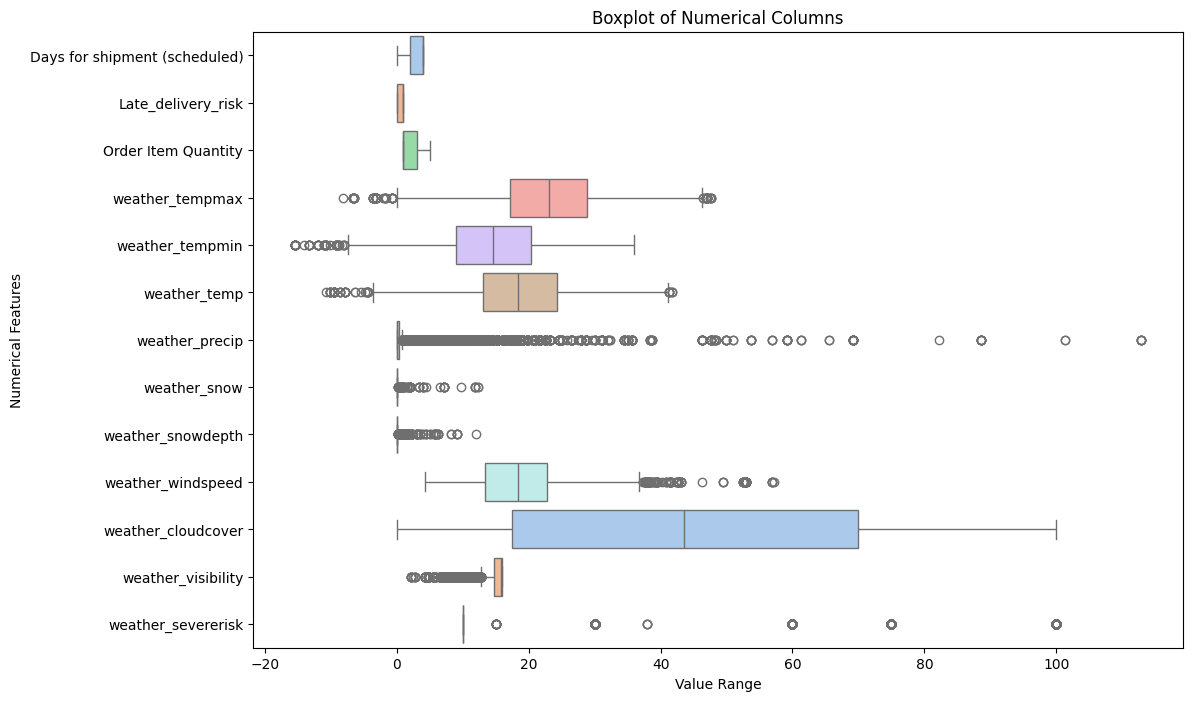

In [21]:
# Boxplot to show the distribution of numerical columns
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_selected[numerical_columns], orient='h', palette="pastel")
plt.title("Boxplot of Numerical Columns")
plt.xlabel("Value Range")
plt.ylabel("Numerical Features")
plt.show()

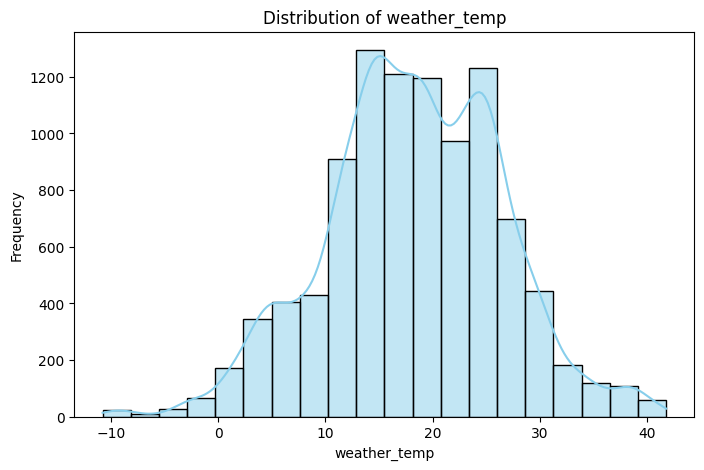

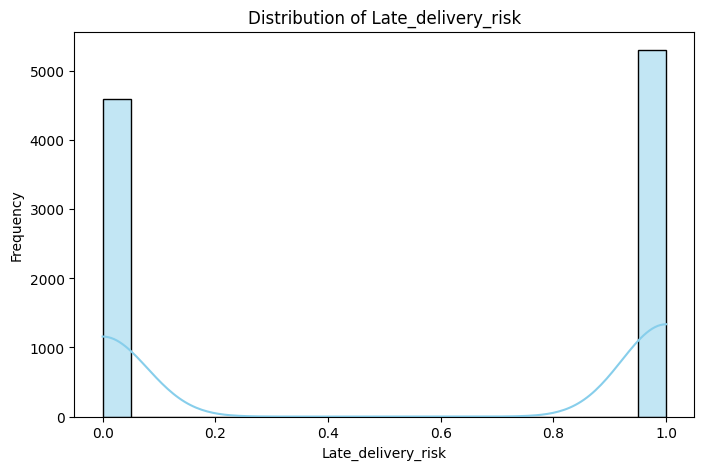

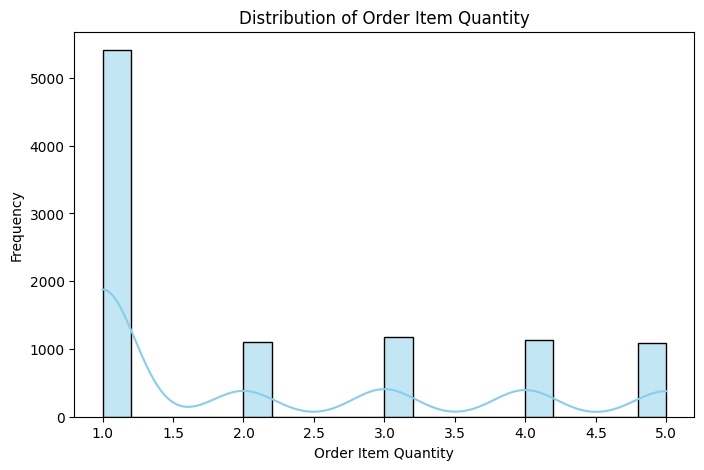

In [22]:
# Plot distribution for selected numerical columns
selected_for_distplot = ['weather_temp', 'Late_delivery_risk', 'Order Item Quantity']
for col in selected_for_distplot:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_selected[col], kde=True, color="skyblue", bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

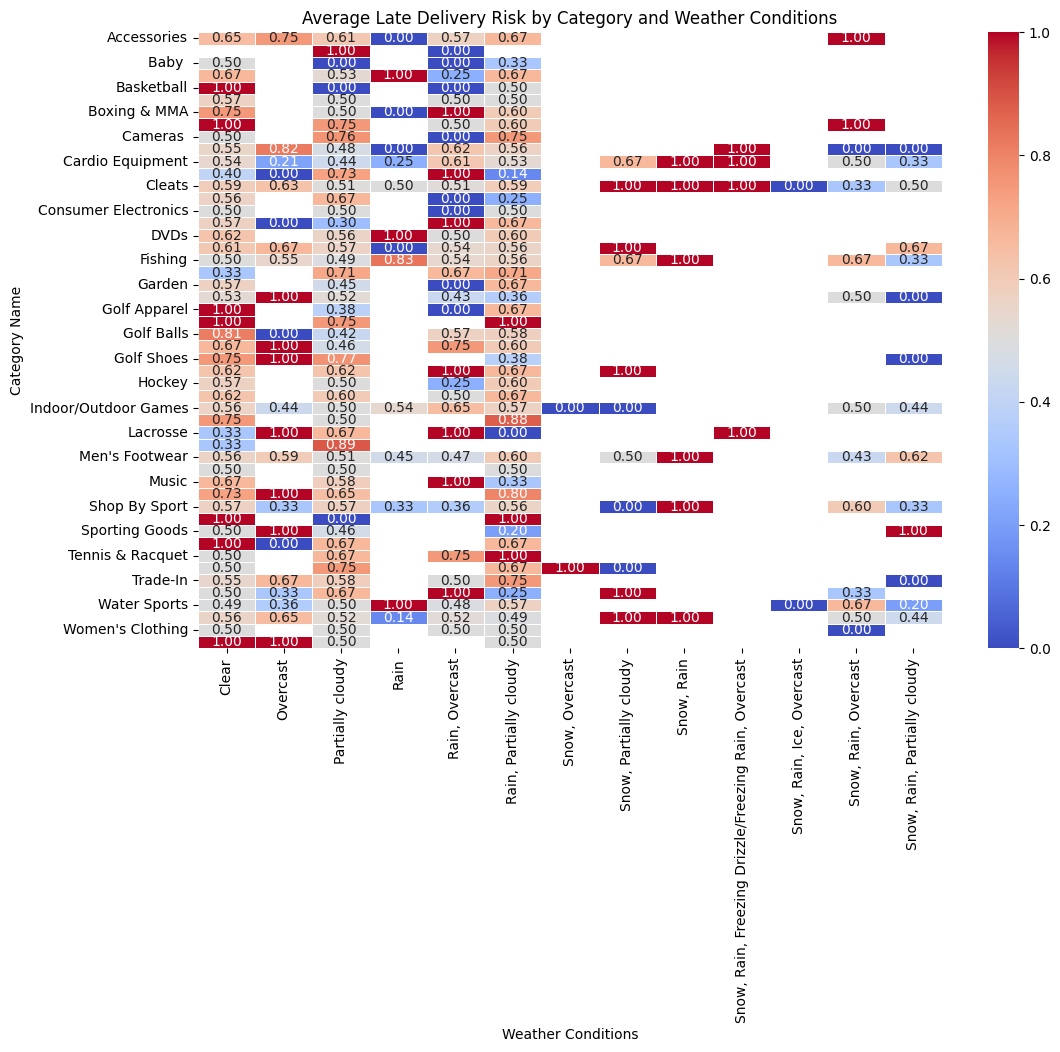

In [23]:
# Pivot table for heatmap
pivot_table = df_selected.pivot_table(
    values='Late_delivery_risk',
    index='Category Name',
    columns='weather_conditions',
    aggfunc='mean'
)

# Heatmap of average late delivery risk
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average Late Delivery Risk by Category and Weather Conditions")
plt.xlabel("Weather Conditions")
plt.ylabel("Category Name")
plt.show()

## <font color ='GREEN'> **Geographic Impact Analysis**

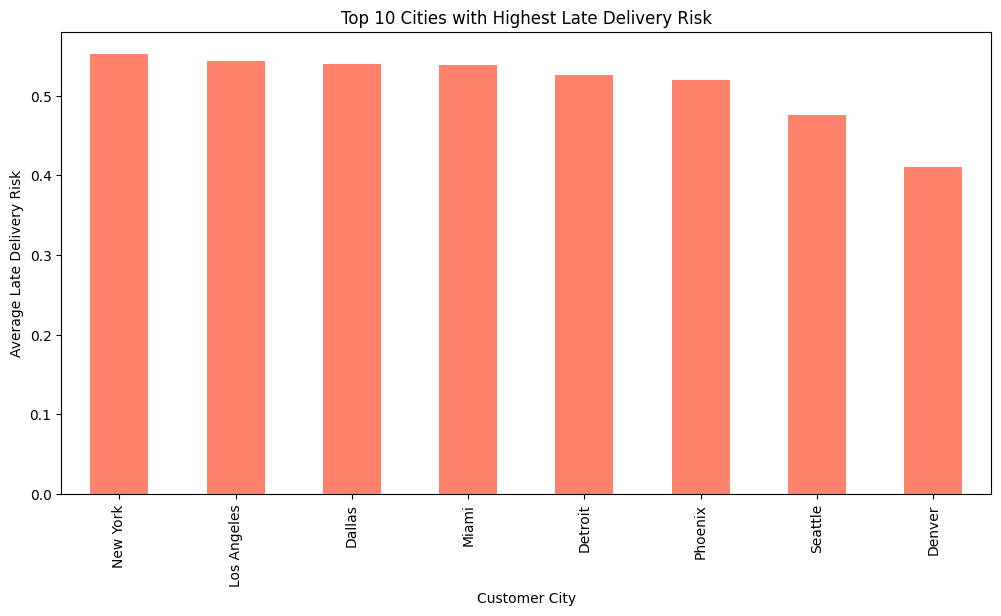

In [24]:
# Group by Customer City and calculate average late delivery risk
city_risk = df_selected.groupby('Customer City')['Late_delivery_risk'].mean().sort_values(ascending=False)

# Plot top cities with highest late delivery risks
plt.figure(figsize=(12, 6))
city_risk.head(10).plot(kind='bar', color='tomato', alpha=0.8)
plt.title('Top 10 Cities with Highest Late Delivery Risk')
plt.xlabel('Customer City')
plt.ylabel('Average Late Delivery Risk')
plt.show()

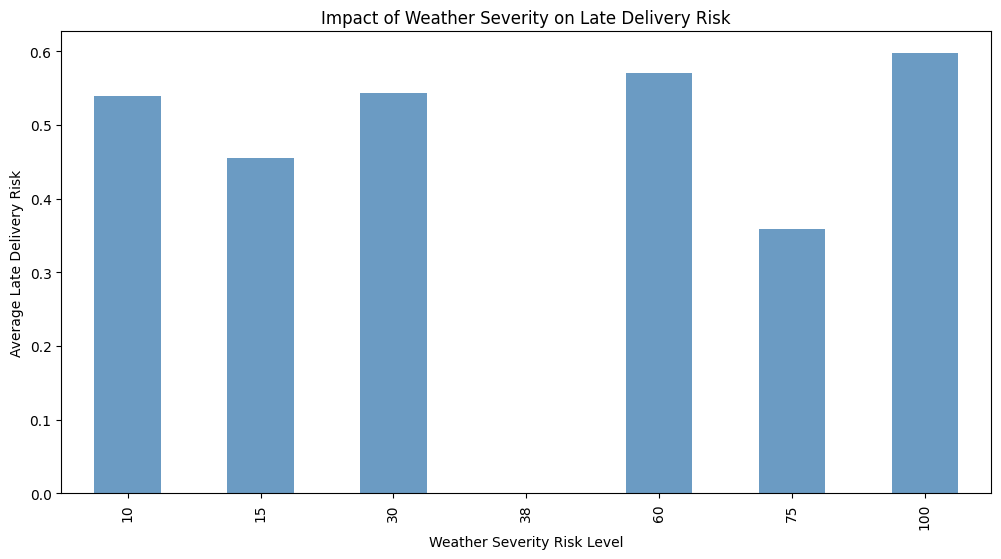

In [25]:
# Group by weather severity and calculate late delivery risk
severity_risk = df_selected.groupby('weather_severerisk')['Late_delivery_risk'].mean()

# Plot relationship
plt.figure(figsize=(12, 6))
severity_risk.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Impact of Weather Severity on Late Delivery Risk')
plt.xlabel('Weather Severity Risk Level')
plt.ylabel('Average Late Delivery Risk')
plt.show()

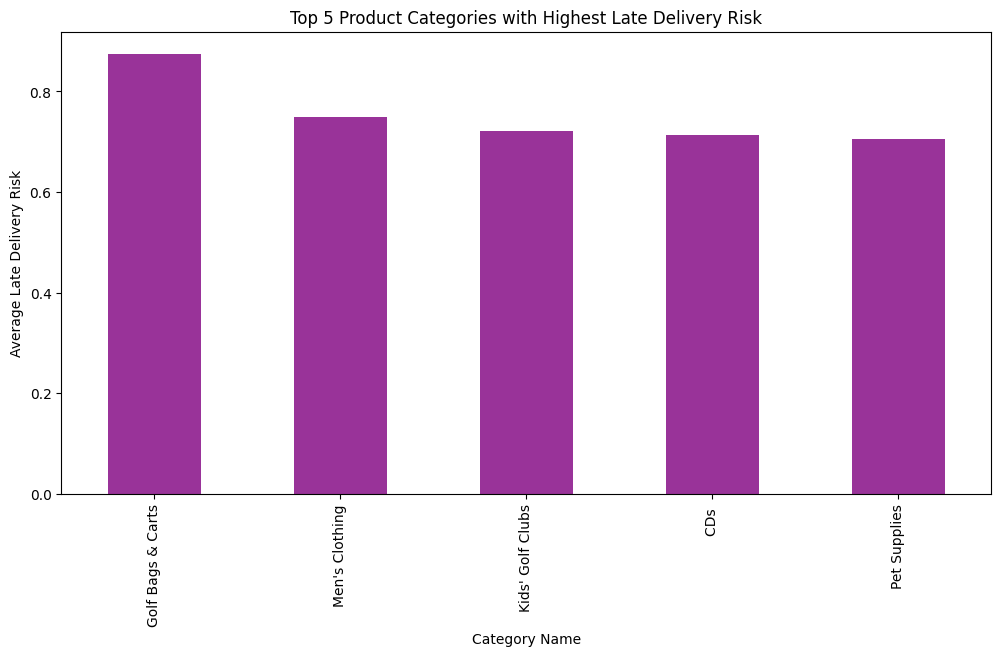

In [26]:
# Group by Category Name and calculate average late delivery risk
category_risk = df_selected.groupby('Category Name')['Late_delivery_risk'].mean().sort_values(ascending=False)

# Plot top 5 categories with highest late delivery risk
plt.figure(figsize=(12, 6))
category_risk.head(5).plot(kind='bar', color='purple', alpha=0.8)
plt.title('Top 5 Product Categories with Highest Late Delivery Risk')
plt.xlabel('Category Name')
plt.ylabel('Average Late Delivery Risk')
plt.show()

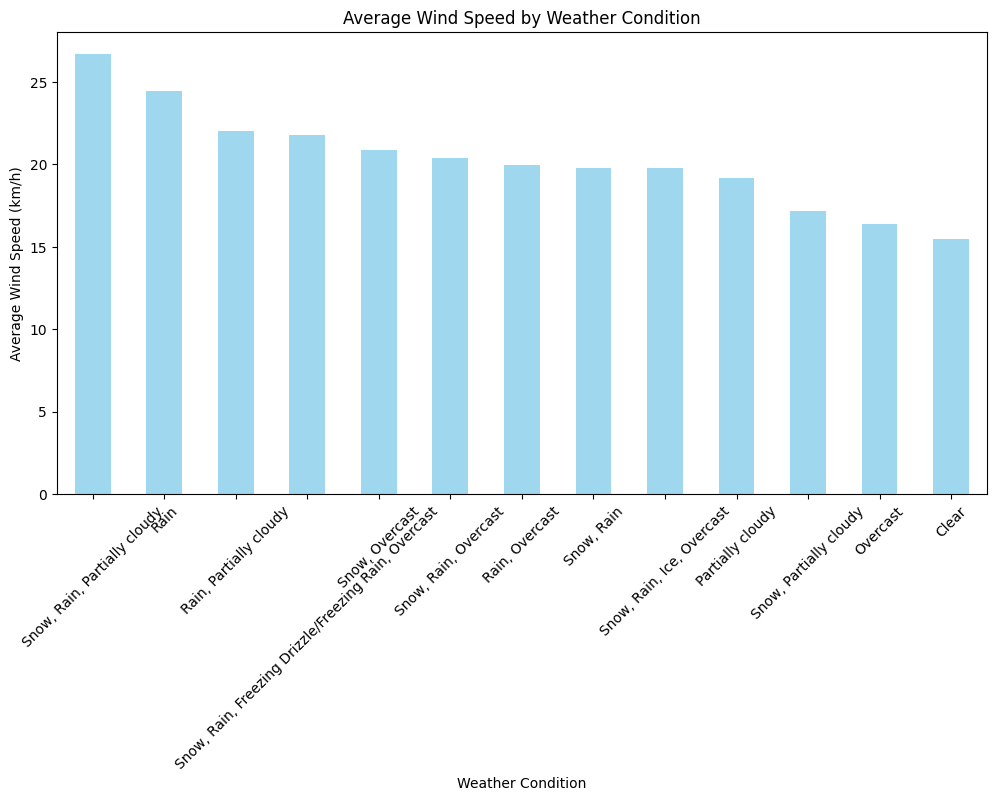

In [27]:
import matplotlib.pyplot as plt

# Grouping by weather conditions to calculate average wind speed and visibility
weather_analysis = df_selected.groupby('weather_conditions')[['weather_windspeed', 'weather_visibility']].mean()

# Plotting average wind speed by weather condition
plt.figure(figsize=(12, 6))
weather_analysis['weather_windspeed'].sort_values(ascending=False).plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Average Wind Speed by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Wind Speed (km/h)')
plt.xticks(rotation=45)
plt.show()

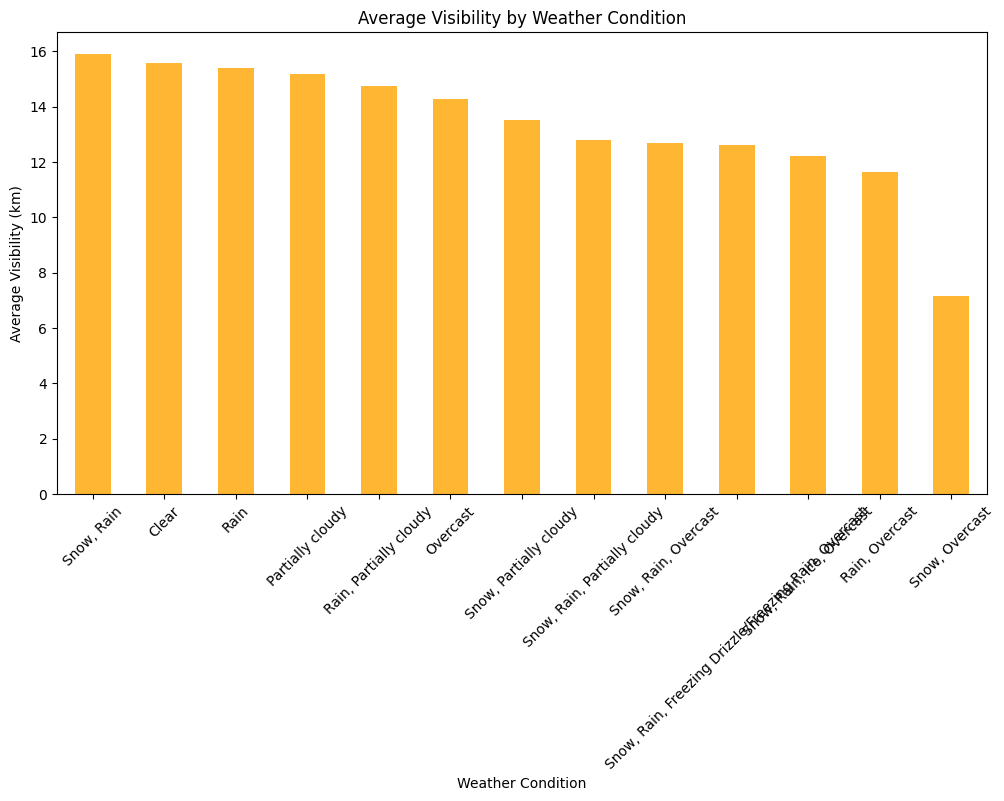

In [28]:
# Plotting average visibility by weather condition
plt.figure(figsize=(12, 6))
weather_analysis['weather_visibility'].sort_values(ascending=False).plot(kind='bar', color='orange', alpha=0.8)
plt.title('Average Visibility by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Visibility (km)')
plt.xticks(rotation=45)
plt.show()

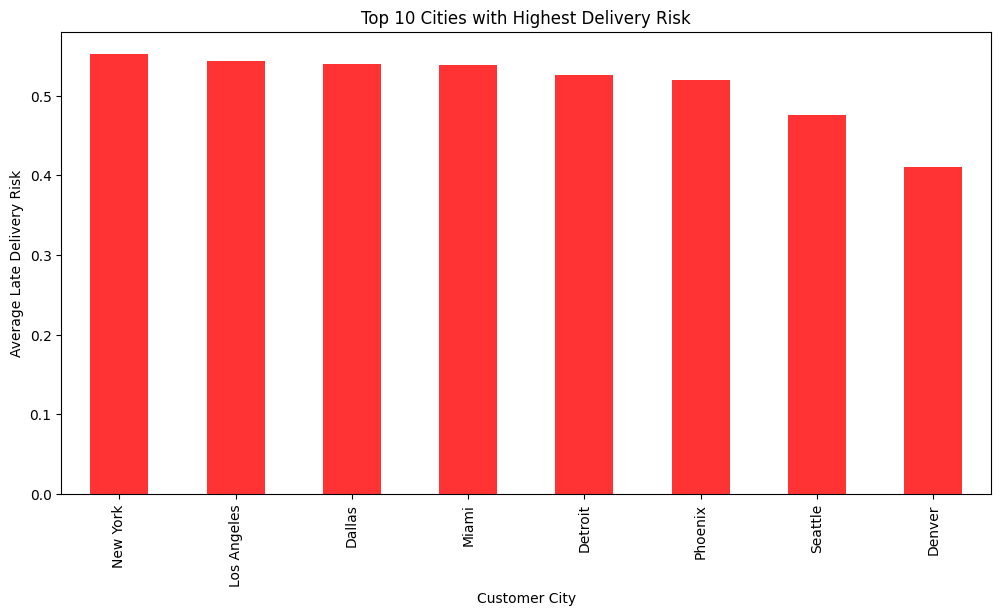

In [29]:
# Grouping by Customer City to calculate average late delivery risk
customer_city_risk = df_selected.groupby('Customer City')['Late_delivery_risk'].mean().sort_values(ascending=False)

# Plotting top 10 cities with highest delivery risk
plt.figure(figsize=(12, 6))
customer_city_risk.head(10).plot(kind='bar', color='red', alpha=0.8)
plt.title('Top 10 Cities with Highest Delivery Risk')
plt.xlabel('Customer City')
plt.ylabel('Average Late Delivery Risk')
plt.show()

## <font color = 'Magenta'> Encoding and Scaling

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import hiplot as hip
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from imblearn.over_sampling import SMOTE
import json
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [50]:
# Replace 'matched_cities_data.csv' path with the actual file name path from your PC below
data = pd.read_excel(r'C:\Users\manos\OneDrive\Desktop\MSU\Fall 2024\STT 810 Math Stat for Data Scientists\Project\data.xlsx') 

df = data[['Days for shipment (scheduled)', 'Late_delivery_risk', 'Category Name', 'Customer City', 
           'Department Name', 'Order Item Quantity', 'shipping_date_day_month', 'weather_tempmax','weather_tempmin', 'weather_temp', 
           'weather_precip', 'weather_preciptype', 'weather_snow', 'weather_snowdepth', 'weather_windspeed', 'weather_cloudcover', 'weather_visibility', 
           'weather_severerisk', 'weather_conditions', 'weather_description']]

#not including 'Delivery Status' and 'Days for shipment (scheduled)' because future data we won't have access to

In [51]:
### Data Quality Assessment
print(df['Category Name'].value_counts())
print(df['Customer City'].value_counts())
print(df['Department Name'].value_counts())
print(df['weather_preciptype'].value_counts())
print(df['weather_conditions'].value_counts())
print(df['weather_description'].value_counts())

Category Name
Cleats                  1345
Men's Footwear          1217
Women's Apparel         1146
Indoor/Outdoor Games    1118
Fishing                  964
Water Sports             799
Camping & Hiking         727
Cardio Equipment         686
Shop By Sport            621
Electronics              183
Accessories               96
Golf Balls                76
Golf Gloves               63
Girls' Apparel            62
Trade-In                  47
Video Games               42
Baseball & Softball       37
Pet Supplies              34
Cameras                   34
Hockey                    32
Children's Clothing       31
Sporting Goods            31
Women's Clothing          30
Computers                 30
Toys                      29
Golf Shoes                28
DVDs                      27
Boxing & MMA              27
Hunting & Shooting        26
Music                     26
Crafts                    24
Consumer Electronics      23
Garden                    23
Health and Beauty         22


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Days for shipment (scheduled)  9900 non-null   int64         
 1   Late_delivery_risk             9900 non-null   int64         
 2   Category Name                  9900 non-null   object        
 3   Customer City                  9900 non-null   object        
 4   Department Name                9900 non-null   object        
 5   Order Item Quantity            9900 non-null   int64         
 6   shipping_date_day_month        9900 non-null   datetime64[ns]
 7   weather_tempmax                9900 non-null   float64       
 8   weather_tempmin                9900 non-null   float64       
 9   weather_temp                   9900 non-null   float64       
 10  weather_precip                 9900 non-null   float64       
 11  weather_preciptyp

In [53]:
#first convert to numerical labels
df = df.copy() 
le = LabelEncoder()
df['Category Name_label'] = le.fit_transform(df['Category Name'])
df['Customer City_label'] = le.fit_transform(df['Customer City'])
df['Department Name_label'] = le.fit_transform(df['Department Name'])
df['weather_preciptype_label'] = le.fit_transform(df['weather_preciptype'])
df['weather_conditions_label'] = le.fit_transform(df['weather_conditions'])
df['weather_description_label'] = le.fit_transform(df['weather_description'])

df.drop(['Category Name', 'Customer City', 'Department Name', 'weather_preciptype', 'weather_conditions', 'weather_description'], axis=1, inplace=True)

In [54]:
#remove bias of labels with binary encoding (nominal data)
def custom_binary_encode(value): 
    return format(value, '02b')

df['Category Name_enc'] = df['Category Name_label'].apply(custom_binary_encode)
df['Customer City_enc'] = df['Customer City_label'].apply(custom_binary_encode)
df['Department Name_enc'] = df['Department Name_label'].apply(custom_binary_encode)
df['weather_preciptype_enc'] = df['weather_preciptype_label'].apply(custom_binary_encode)
df['weather_conditions_enc'] = df['weather_conditions_label'].apply(custom_binary_encode)
df['weather_description_enc'] = df['weather_description_label'].apply(custom_binary_encode)

#drop repetitive columns
df.drop(['Category Name_label', 'Customer City_label', 'Department Name_label', 'weather_preciptype_label', 'weather_conditions_label', 'weather_description_label'], axis=1, inplace=True)

In [55]:
#drop missing rows
df = df.dropna(axis=0)

In [56]:
#handle datetime64 col
df['shipping_day'] = df['shipping_date_day_month'].dt.day
df['shipping_month'] = df['shipping_date_day_month'].dt.month
df.drop('shipping_date_day_month', axis=1, inplace=True)

In [57]:
#scale numeric data
num_col = df.select_dtypes(include=['int', 'float']).columns
num_col = [col for col in num_col if col != 'Late_delivery_risk'] #don't scale target variable
scaler = RobustScaler(copy=True)
df_scaled = scaler.fit_transform(df[num_col])
df_scaled = pd.DataFrame(df_scaled, columns=num_col)
df_scaled = pd.concat([df_scaled, df.drop(columns=num_col)], axis=1)
print(df_scaled.head())

   Days for shipment (scheduled)  Order Item Quantity  weather_tempmax  \
0                           -1.5                  0.0         0.059829   
1                           -1.5                  0.0        -0.222222   
2                            0.0                  0.0         0.273504   
3                            0.0                  1.5         0.589744   
4                            0.0                  2.0         0.076923   

   weather_tempmin  weather_temp  weather_precip  weather_snow  \
0         0.000000      0.079646            0.00           0.0   
1        -0.566372     -0.327434            0.00           0.0   
2        -0.212389      0.017699            0.00           0.0   
3         0.557522      0.592920            0.00           0.0   
4         0.566372      0.327434           48.36           0.0   

   weather_snowdepth  weather_windspeed  weather_cloudcover  ...  \
0                0.0           1.489362            0.106870  ...   
1                0.0  

## <font color = 'Magenta'> Feature Engineering

In [58]:
numerical = num_col
categorical = ['Category Name_enc', 'Customer City_enc', 'Department Name_enc', 'weather_preciptype_enc', 'weather_conditions_enc', 'weather_description_enc']

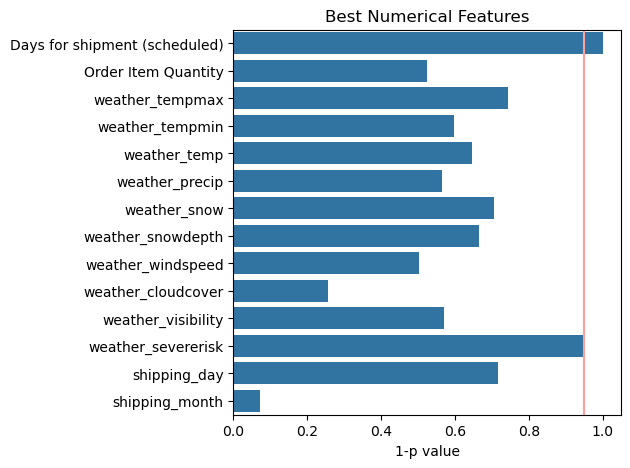

In [76]:
#T Test for numerical columns (feature has strong evidence of a significant difference between the groups)
p=[]
from scipy.stats import ttest_ind
for i in numerical:
    df1=df_scaled.groupby('Late_delivery_risk').get_group(0)
    df2=df_scaled.groupby('Late_delivery_risk').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(5,5))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r') #test result is considered statistically significant (with 95% confidence)
plt.xlabel('1-p value')
plt.show()

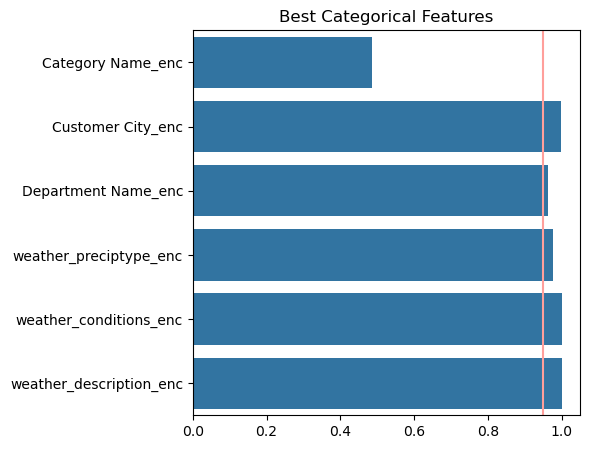

In [77]:
#Chi Square test for Categorical Columns (feature has strong evidence of a significant difference between the groups)
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df_scaled['Late_delivery_risk'],df_scaled[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(5,5))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r') #test result is considered statistically significant (with 95% confidence)
plt.show()

## <font color = 'Magenta'> Pre-processing for Model

In [61]:
x = df_scaled.drop(columns = 'Late_delivery_risk')
y = df_scaled['Late_delivery_risk']

#will train on 70% of the data, test on the remaining 30%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=50)

In [62]:
x_train.shape[0]

6930

In [63]:
x_test.shape[0]

2970

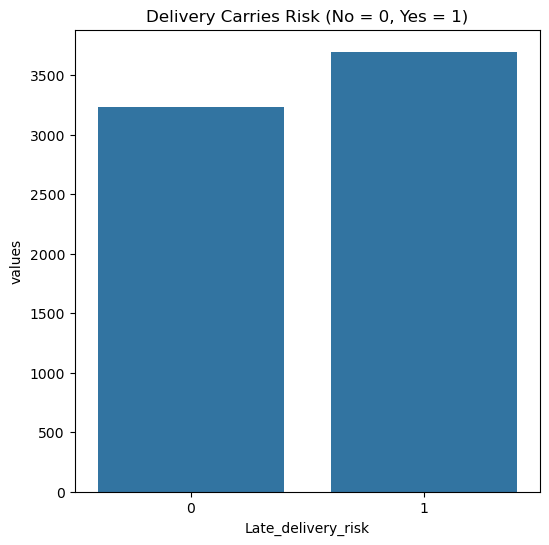

In [64]:
### Class Imbalance

#check imbalance
temp = y_train.value_counts()
df = pd.DataFrame({'Late_delivery_risk': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Delivery Carries Risk (No = 0, Yes = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'Late_delivery_risk', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

## <font color = 'Magenta'> Modelling

In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

#### Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 1, 10]}

lr = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000, solver='liblinear')
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, n_jobs = -1, verbose=1)

In [67]:
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6892255892255892
[[1106  258]
 [ 665  941]]
              precision    recall  f1-score   support

           0       0.62      0.81      0.71      1364
           1       0.78      0.59      0.67      1606

    accuracy                           0.69      2970
   macro avg       0.70      0.70      0.69      2970
weighted avg       0.71      0.69      0.69      2970



In [68]:
#Validate high accuracy using cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, x_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {scores.mean()} ± {scores.std()}')

#on average, your model correctly predicts the target variable 69.77% of the time across different validation sets
#Confidence Interval: s.d of 1.29% suggests the model's performance is stable across cross-validation folds

Cross-Validation Accuracy: 0.6976911976911977 ± 0.012946867564881948


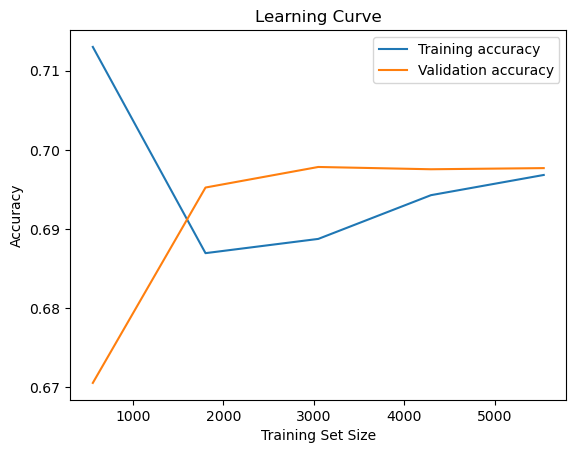

In [69]:
#helps visualize if the model is overfitting (i.e., a large gap between training and validation accuracy)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(lr, x_train, y_train, cv=5, scoring='accuracy')

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [70]:
# Coefficients for feature importance
grid_search.fit(x_train, y_train)
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(x_test)

coefficients = best_lr_model.coef_[0] 
feature_names = x_train.columns
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)
print(coeff_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
                          Feature   Coefficient  Abs_Coefficient
0   Days for shipment (scheduled) -1.188791e+00     1.188791e+00
6                    weather_snow  1.241194e-01     1.241194e-01
7               weather_snowdepth  1.000057e-01     1.000057e-01
12                   shipping_day -8.137287e-02     8.137287e-02
13                 shipping_month  3.526436e-02     3.526436e-02
3                 weather_tempmin  3.471812e-02     3.471812e-02
10             weather_visibility  2.615772e-02     2.615772e-02
2                 weather_tempmax -2.592007e-02     2.592007e-02
4                    weather_temp  2.306603e-02     2.306603e-02
8               weather_windspeed -2.218442e-02     2.218442e-02
9              weather_cloudcover  7.042038e-03     7.042038e-03
11             weather_severerisk -2.465262e-03     2.465262e-03
17         weather_preciptype_enc -1.712210e-03     1.712210e-03
1             Order Item Quant

#### Gaussian Naive Bayes for Continuous + Multinomial Naive Bayes for Categorical Data

Multinomial Naive Bayes is designed to handle discrete (categorical) features and works well when the features are independent given the class.
For continuous features, use Gaussian Naive Bayes, which assumes that the continuous features are normally distributed for each class.

In [71]:
#make numerical data normally distrubuted
scaler = StandardScaler()
x_train[numerical] = scaler.fit_transform(x_train[numerical])

In [72]:
# Define separate classifiers
cat_classifier = MultinomialNB()  #for categorical features
num_classifier = GaussianNB()  #for continuous features

#split categorical and numerical features
x_train_cat = x_train[categorical]
x_test_cat = x_test[categorical]
x_train_num = x_train[numerical]
x_test_num = x_test[numerical]

cat_classifier.fit(x_train_cat, y_train)
num_classifier.fit(x_train_num, y_train)

#combine both model predictions
cat_pred = cat_classifier.predict(x_test_cat)
num_pred = num_classifier.predict(x_test_num)

#combine predictions using majority vote or other method
#simple form of ensemble learning where the predictions of multiple models are merged to form a final prediction. By averaging the values, the model gives more weight to consistent predictions from both classifiers.
final_pred = (cat_pred + num_pred) / 2
final_pred = [1 if x >= 0.5 else 0 for x in final_pred]

print("Accuracy:",metrics.accuracy_score(y_test, final_pred))
print(confusion_matrix(y_test, final_pred))
print(classification_report(y_test, final_pred))

Accuracy: 0.5787878787878787
[[ 317 1047]
 [ 204 1402]]
              precision    recall  f1-score   support

           0       0.61      0.23      0.34      1364
           1       0.57      0.87      0.69      1606

    accuracy                           0.58      2970
   macro avg       0.59      0.55      0.51      2970
weighted avg       0.59      0.58      0.53      2970



In [73]:
#Validate high accuracy using cross-validation
cat_scores = cross_val_score(cat_classifier, x_train_cat, y_train, scoring='accuracy')
print(f'Cross-Validation Accuracy for Multinomial NB: {cat_scores.mean()} ± {cat_scores.std()}')

num_scores = cross_val_score(num_classifier, x_train_num, y_train, scoring='accuracy')
print(f'Cross-Validation Accuracy for Gaussian NB: {num_scores.mean()} ± {num_scores.std()}')

#Multinomial Naive Bayes is performing poorly with an average accuracy of around 51.89%, with relatively small variation across the folds (± 1.40%).
#Gaussian Naive Bayes is performing better with an average accuracy of around 66.71%, with a higher variation (± 3.55%).

Cross-Validation Accuracy for Multinomial NB: 0.5189033189033189 ± 0.013956144202741912
Cross-Validation Accuracy for Gaussian NB: 0.667099567099567 ± 0.03554473139713673


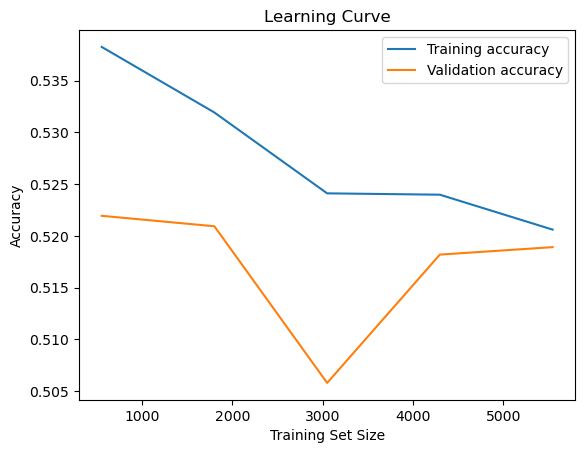

In [74]:
train_sizes, train_scores, val_scores = learning_curve(cat_classifier, x_train_cat, y_train, cv=5, scoring='accuracy')

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

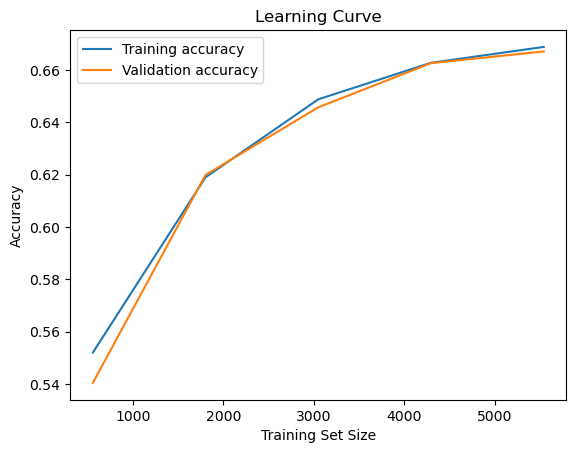

In [75]:
train_sizes, train_scores, val_scores = learning_curve(num_classifier, x_train_num, y_train, cv=5, scoring='accuracy')

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()